# Iris Data Generation

# Index

1. [Libraries](#Libraries)
2. [Data Preparation](#Getting-Started)
3. [Exploring Architectures](#GAN-vs-VAE)
4. [Generating Syntethic Data](#Conditional-Generative-Adversarial-Network)
5. [Making the model shiny](#Fine-Tuning-the-CGAN)

## Libraries

In [1]:
import sys
import os

import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import skew, kurtosis, iqr, ks_2samp

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchmetrics

import random
from tqdm.auto import tqdm

Seed function for reproducibility.

In [2]:
def set_seed(seed = 0):
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [3]:
project_path = os.path.abspath("..")

if project_path not in sys.path:
    sys.path.append(project_path)

import utils

## Getting Started
The iris dataset will be used to validate the tabular data generation protocol, which despite its apparent simplicity may harbor pitfalls.

In [4]:
X, y = load_iris()['data'], load_iris()['target']
features, species = load_iris()['feature_names'], load_iris()['target_names']

real_iris = pd.DataFrame(X, columns = features)
real_iris['target'] = y
real_iris['target'] = real_iris['target'].map({i: species[i] for i in range(len(species))})
real_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Let's deep dive into our real data.

In [5]:
utils.describe_data(real_iris, 'target')

REAL                     
                       setosa versicolor virginica
MEAN sepal length (cm)  5.006      5.936     6.588
     sepal width (cm)   3.428      2.770     2.974
     petal length (cm)  1.462      4.260     5.552
     petal width (cm)   0.246      1.326     2.026
STD  sepal length (cm)  0.352      0.516     0.636
     sepal width (cm)   0.379      0.314     0.322
     petal length (cm)  0.174      0.470     0.552
     petal width (cm)   0.105      0.198     0.275
MIN  sepal length (cm)  4.300      4.900     4.900
     sepal width (cm)   2.300      2.000     2.200
     petal length (cm)  1.000      3.000     4.500
     petal width (cm)   0.100      1.000     1.400
MAX  sepal length (cm)  5.800      7.000     7.900
     sepal width (cm)   4.400      3.400     3.800
     petal length (cm)  1.900      5.100     6.900
     petal width (cm)   0.600      1.800     2.500
SKEW sepal length (cm)  0.116      0.102     0.114
     sepal width (cm)   0.040     -0.352     0.355
     petal length (cm)  0.103     -0.588     0.533
     petal width (cm)   1.216     -0.030    -0.126
KURT sepal length (cm) -0.346     -0.599    -0.088
     sepal width (cm)   0.744     -0.448     0.520
     petal length (cm)  0.805     -0.074    -0.256
     petal width (cm)   1.434     -0.488    -0.661
IQR  sepal length (cm)  0.400      0.700     0.675
     sepal width (cm)   0.475      0.475     0.375
     petal length (cm)  0.175      0.600     0.775
     petal width (cm)   0.100      0.300     0.500

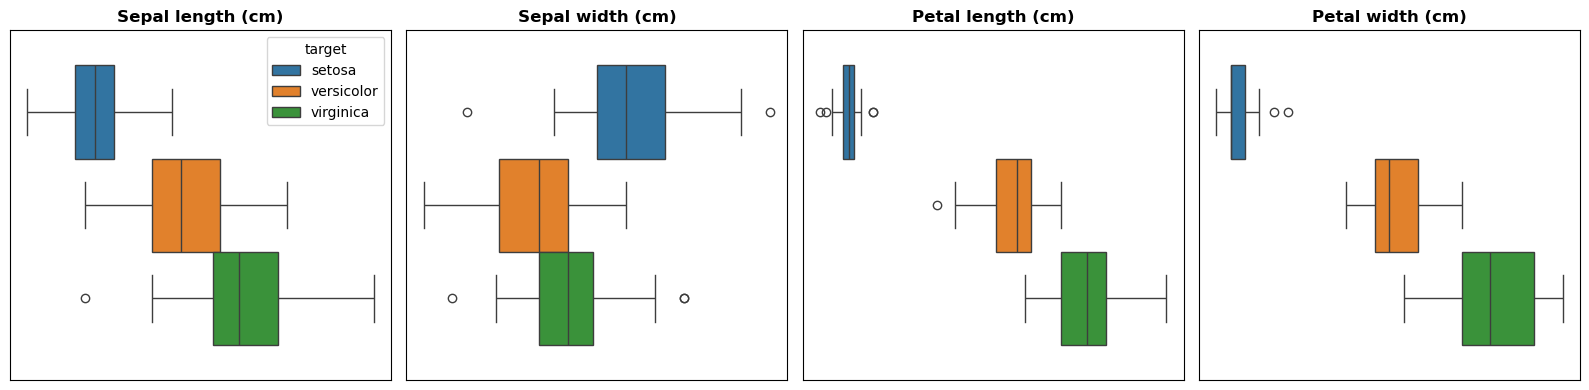

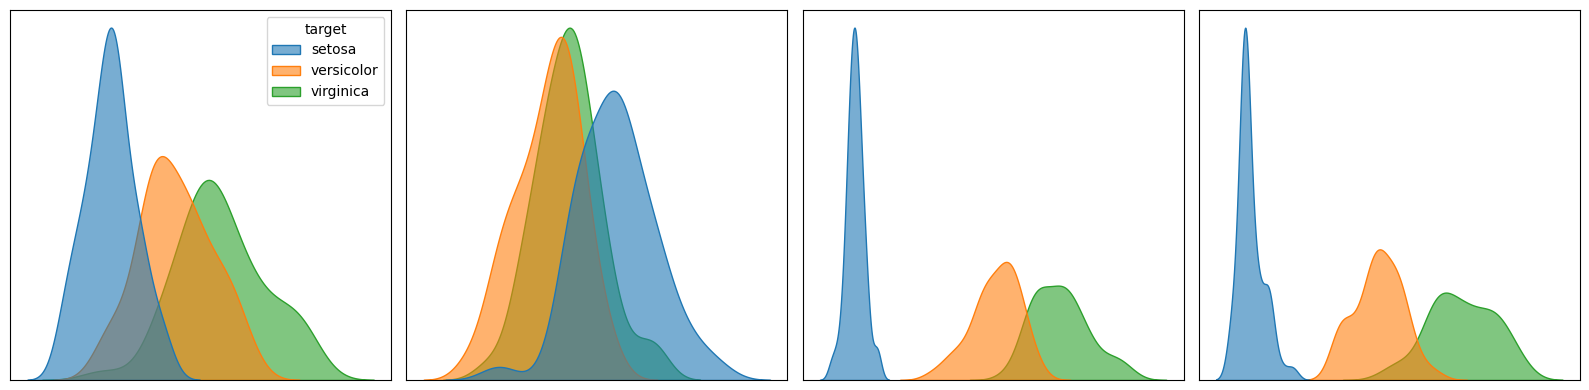

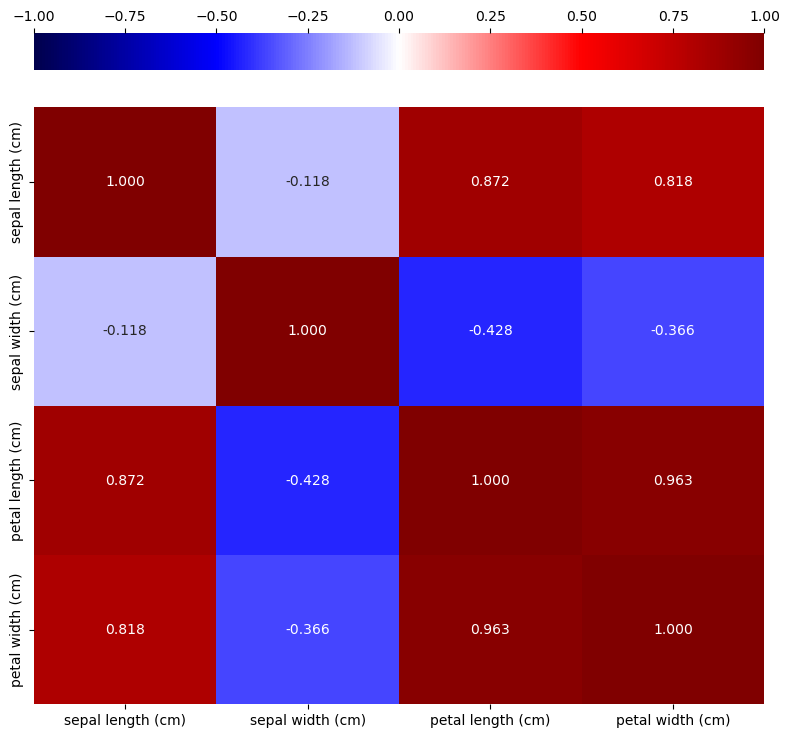

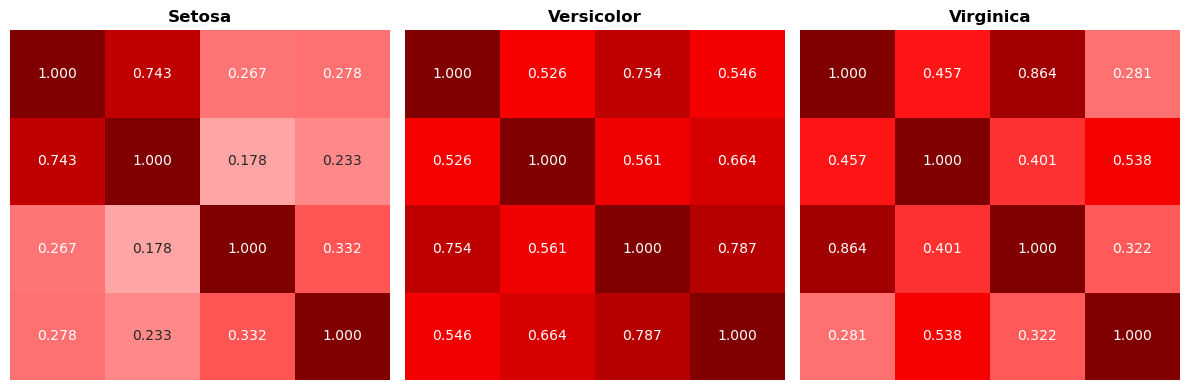

In [6]:
utils.plot_data(real_iris, 'target')

Throughout the notebook we will make comparisons between two datasets, one real and one synthetic; the following dataset, generated by adding normal noise to the real one, is used to introduce the comparison functions.

In [7]:
df = real_iris.select_dtypes('number') + np.random.normal(0, 1, (150,4))
df['target'] = real_iris['target']
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,2.556657,1.297439,2.638893,-0.029180,setosa
1,3.868639,3.821823,0.508922,0.596701,setosa
2,2.891022,5.135167,-0.074932,0.465933,setosa
3,5.304264,1.986028,2.073862,-1.828396,setosa
4,3.768107,4.427320,1.273565,0.669065,setosa


Let's start with comparisons! 

First of all a simply comparison between descriptives.

In [8]:
utils.describe_data(real_iris, 'target', df)

REAL                      SYNTHETIC             \
                       setosa versicolor virginica    setosa versicolor   
MEAN sepal length (cm)  5.006      5.936     6.588     4.799      6.022   
     sepal width (cm)   3.428      2.770     2.974     3.448      2.830   
     petal length (cm)  1.462      4.260     5.552     1.394      4.102   
     petal width (cm)   0.246      1.326     2.026     0.564      1.179   
STD  sepal length (cm)  0.352      0.516     0.636     0.988      1.008   
     sepal width (cm)   0.379      0.314     0.322     1.107      1.041   
     petal length (cm)  0.174      0.470     0.552     1.111      0.936   
     petal width (cm)   0.105      0.198     0.275     0.919      1.035   
MIN  sepal length (cm)  4.300      4.900     4.900     2.557      4.011   
     sepal width (cm)   2.300      2.000     2.200     1.283     -0.028   
     petal length (cm)  1.000      3.000     4.500    -1.803      1.894   
     petal width (cm)   0.100      1.000     1.400    -1.828     -0.826   
MAX  sepal length (cm)  5.800      7.000     7.900     6.696      8.667   
     sepal width (cm)   4.400      3.400     3.800     5.860      5.070   
     petal length (cm)  1.900      5.100     6.900     3.881      6.191   
     petal width (cm)   0.600      1.800     2.500     2.814      3.204   
SKEW sepal length (cm)  0.116      0.102     0.114    -0.137      0.177   
     sepal width (cm)   0.040     -0.352     0.355     0.125     -0.204   
     petal length (cm)  0.103     -0.588     0.533    -0.328      0.070   
     petal width (cm)   1.216     -0.030    -0.126     0.051     -0.151   
KURT sepal length (cm) -0.346     -0.599    -0.088    -0.314     -0.014   
     sepal width (cm)   0.744     -0.448     0.520    -0.438     -0.214   
     petal length (cm)  0.805     -0.074    -0.256     0.657     -0.485   
     petal width (cm)   1.434     -0.488    -0.661     0.591     -0.578   
IQR  sepal length (cm)  0.400      0.700     0.675     1.071      1.344   
     sepal width (cm)   0.475      0.475     0.375     1.451      1.560   
     petal length (cm)  0.175      0.600     0.775     1.238      1.338   
     petal width (cm)   0.100      0.300     0.500     0.891      1.408   

                                  
                       virginica  
MEAN sepal length (cm)     6.351  
     sepal width (cm)      3.121  
     petal length (cm)     5.553  
     petal width (cm)      2.021  
STD  sepal length (cm)     0.947  
     sepal width (cm)      0.984  
     petal length (cm)     1.141  
     petal width (cm)      1.091  
MIN  sepal length (cm)     4.509  
     sepal width (cm)      1.388  
     petal length (cm)     3.409  
     petal width (cm)     -0.233  
MAX  sepal length (cm)     8.395  
     sepal width (cm)      5.126  
     petal length (cm)     9.029  
     petal width (cm)      4.298  
SKEW sepal length (cm)     0.261  
     sepal width (cm)      0.260  
     petal length (cm)     0.333  
     petal width (cm)     -0.029  
KURT sepal length (cm)    -0.392  
     sepal width (cm)     -0.952  
     petal length (cm)     0.414  
     petal width (cm)     -0.804  
IQR  sepal length (cm)     1.195  
     sepal width (cm)      1.408  
     petal length (cm)     1.398  
     petal width (cm)      1.616

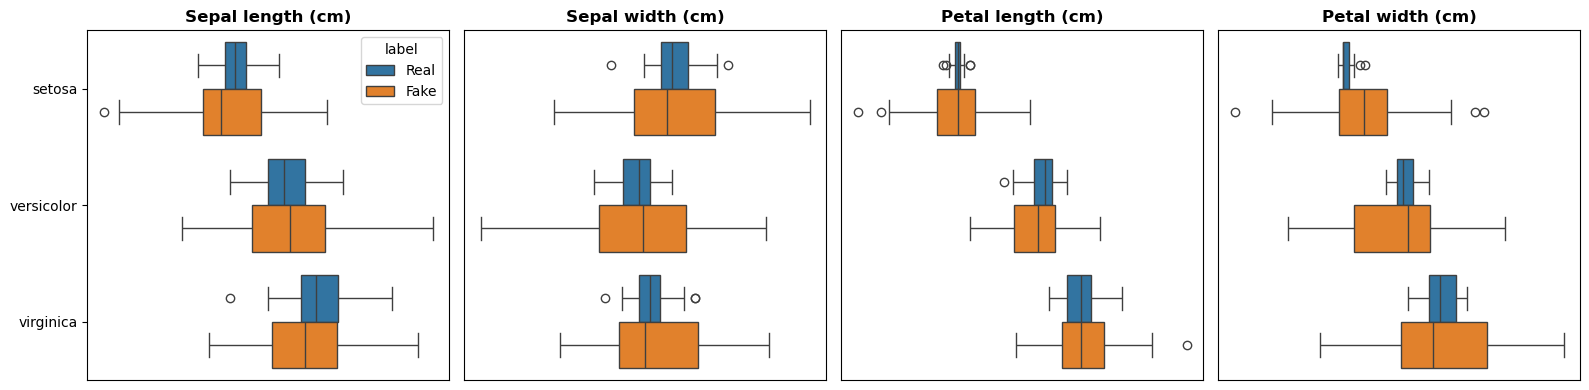

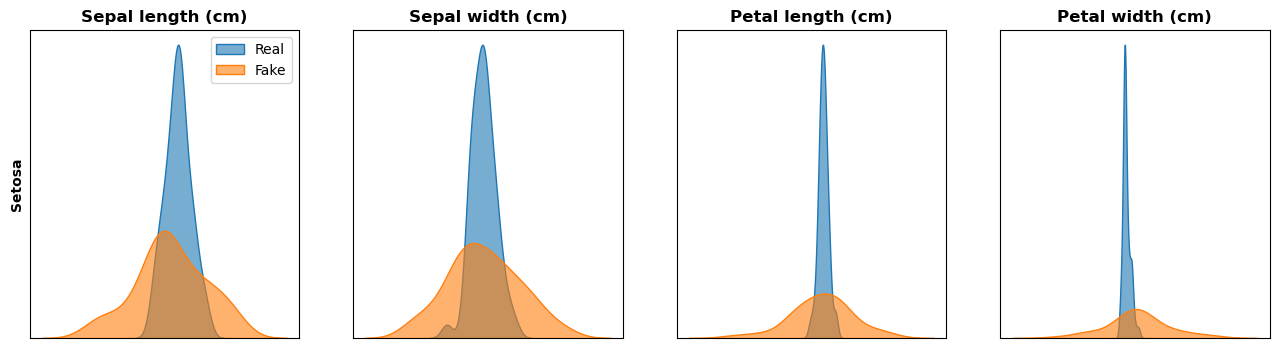

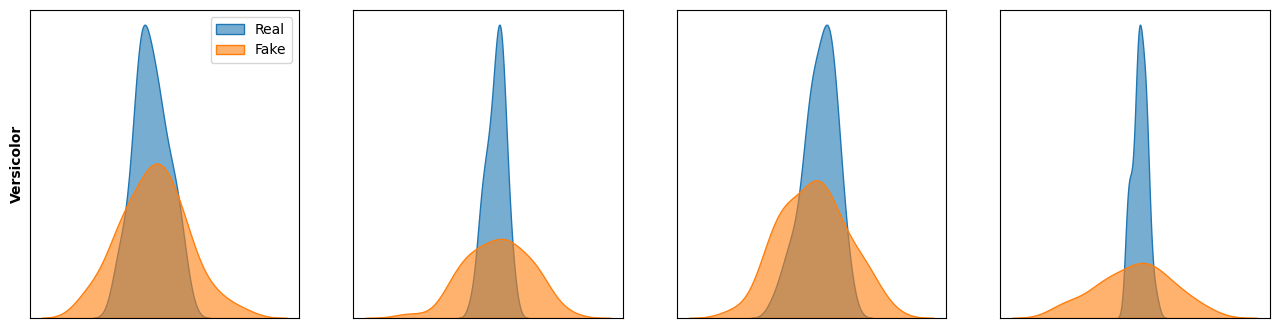

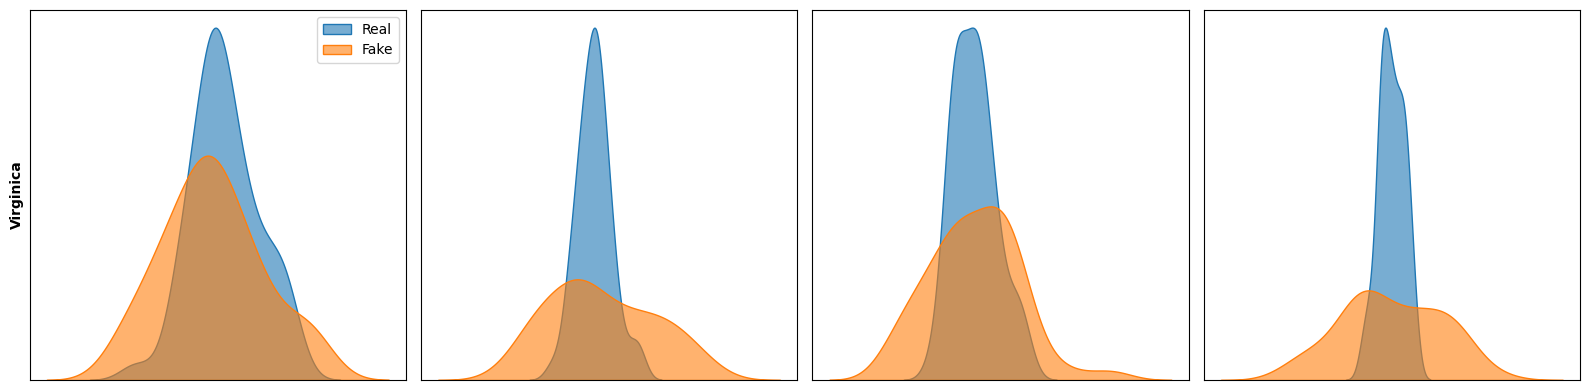

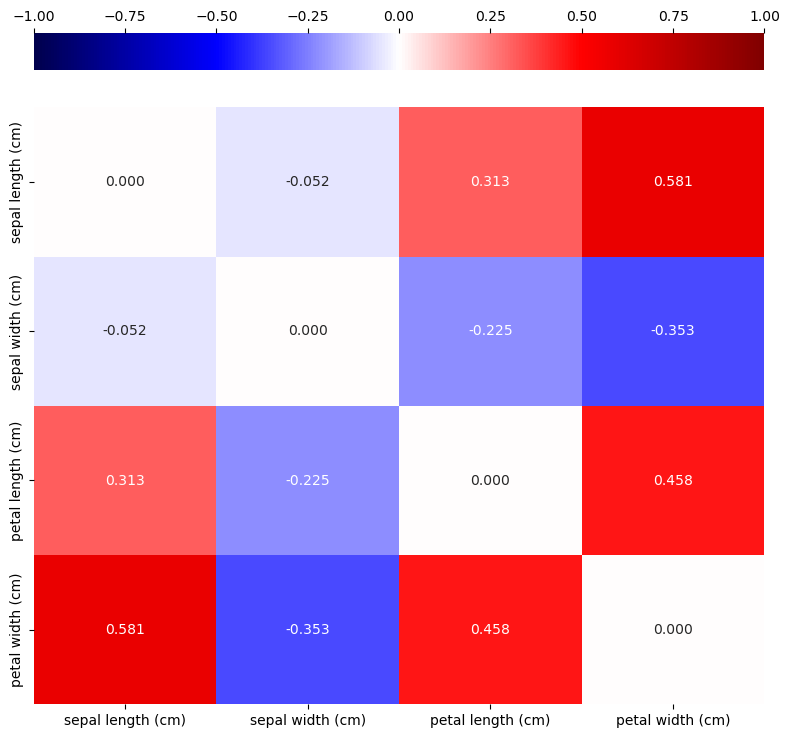

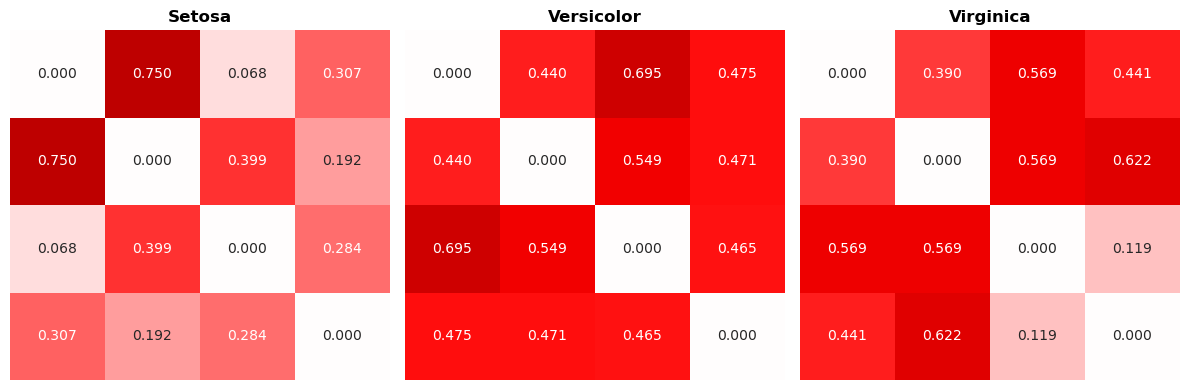

In [9]:
utils.plot_data(real_iris, 'target', df)

Throughout the work, the goal will be to minimize the differences, numerical and graphical, between the actual and synthetic data. Two different architectures will be used to achieve this goal: the Variational Auto Encoder **(VAE)** and the Generative Adversarial Network **(GAN)**, and the one that will show the best performance for the same task complexity and resources will be selected.

## GAN vs VAE

Both valid, the two approaches show different challenges and advantages:

1. **Variational Auto Encoder**:

Pros:
- Easy to train
- We can look inside the neaural network "Black Box"

Cons:

- Less coverage of variability
- Assumption of data normality

2. **Generative Adversarial Network**:

Pros:
- More realistic generated data
- Flexibility with respect to actual data distributions

Cons:
- Hard to train (model collapse, lot of resources, lot of data)
- Lower interpretability

The performance of the two architectures will be analyzed using them in as simple a version as possible. The next step will then be to prepare the data for modeling.

In [10]:
std_scl = StandardScaler()
X_scld = std_scl.fit_transform(X)

ohe = OneHotEncoder(sparse_output = False)
y_ohe = ohe.fit_transform(y.reshape(-1,1))

Preparing Torch Dataset and Dataloader

In [11]:
class IrisDataset(Dataset):
    def __init__(self, data, target):
        self.data = torch.tensor(data, dtype = torch.float32)
        self.label = torch.tensor(target, dtype = torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]
    
real_vae_dataset = IrisDataset(X_scld, y_ohe)
real_vae_dataloader = DataLoader(real_vae_dataset, batch_size = 32, shuffle = True)

real_gan_dataset = IrisDataset(X_scld, y)
real_gan_dataloader = DataLoader(real_gan_dataset, batch_size = 32, shuffle = True)

for dataloader in [real_vae_dataloader, real_gan_dataloader]:
    for batch in dataloader:
        print(f'Data shape: {batch[0].shape}, labels shape: {batch[1].shape}')
        break

Data shape: torch.Size([32, 4]), labels shape: torch.Size([32, 3])
Data shape: torch.Size([32, 4]), labels shape: torch.Size([32])


Let's build baseline models, starting with the Conditional VAE

In [12]:
class ConditionalVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, condition_dim):
        super(ConditionalVAE, self).__init__()
        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + condition_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
        )
        
        self.fc_mu = nn.Linear(16, latent_dim)
        self.fc_logvar = nn.Linear(16, latent_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + condition_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim),
            nn.Tanh()
        )
        
    def encode(self, x, c):
        x_cond = torch.cat([x, c], dim=1)
        h = self.encoder(x_cond)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        z_cond = torch.cat([z, c], dim=1)
        return self.decoder(z_cond)

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, c)
        return recon_x, mu, logvar
    
set_seed()
vae = ConditionalVAE(input_dim = 4, latent_dim = 4, condition_dim = 3)

for batch in real_vae_dataloader:
    vae_batch = batch
    break
    
vae_out = vae(vae_batch[0], vae_batch[1])
for out in vae_out:
    print(f'Shape: {out.shape}')

Shape: torch.Size([32, 4])
Shape: torch.Size([32, 4])
Shape: torch.Size([32, 4])


Now let's build the GANs net.

In [13]:
class Generator(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 4),
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x
    
class Discriminator(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
            
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x

set_seed()    
gen = Generator(input_dim = 4, num_classes = 3)
disc = Discriminator(input_dim = 4, num_classes = 3)

for batch in real_gan_dataloader:
    gan_batch = batch
    break
    
print(f'Generator output shape: {gen(torch.randn(32, 4), gan_batch[1]).shape}')
print(f'Discriminator output shape: {disc(gan_batch[0], gan_batch[1]).shape}')

Generator output shape: torch.Size([32, 4])
Discriminator output shape: torch.Size([32, 1])


Let's check models' size in parameters.

In [14]:
print(f'VAE has {sum(p.numel() for p in vae.parameters())} parameters')
print(f'Gen has {sum(p.numel() for p in gen.parameters())} parameters')
print(f'Disc has {sum(p.numel() for p in disc.parameters())} parameters')

VAE has 1724 parameters
Gen has 861 parameters
Disc has 810 parameters


We can now train the simpliest Conditional VAE.

In [15]:
vae_opt = torch.optim.Adam(vae.parameters(), lr = 1e-3)

def vae_loss(reconstructed, original, mu, logvar, beta=1.0):
    recon_loss = F.mse_loss(reconstructed, original, reduction='mean')
    
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl_div /= original.size(0)

    total_loss = recon_loss + beta * kl_div
    return total_loss, recon_loss, kl_div

set_seed()

z = torch.randn(150, 4)
z[:10]

tensor([[-1.1258, -1.1524, -0.2506, -0.4339],
        [ 0.8487,  0.6920, -0.3160, -2.1152],
        [ 0.3223, -1.2633,  0.3500,  0.3081],
        [ 0.1198,  1.2377,  1.1168, -0.2473],
        [-1.3527, -1.6959,  0.5667,  0.7935],
        [ 0.5988, -1.5551, -0.3414,  1.8530],
        [ 0.7502, -0.5855, -0.1734,  0.1835],
        [ 1.3894,  1.5863,  0.9463, -0.8437],
        [-0.6136,  0.0316, -0.4927,  0.2484],
        [ 0.4397,  0.1124,  0.6408,  0.4412]])

In [16]:
for epoch in tqdm(range(1, 501), desc = 'Training VAE'):
    
    vae.train()
    epoch_loss = 0
    
    for data, label in real_vae_dataloader:
        
        reconstructed, mu, logvar = vae(data, label)
        loss, recon_loss, kl_div = vae_loss(reconstructed, data, mu, logvar)
        
        vae_opt.zero_grad()
        loss.backward()
        vae_opt.step()
        
        epoch_loss += loss.item()
        
    epoch_total_loss = epoch_loss/len(real_vae_dataloader)
    
    if epoch % 50 == 0 or epoch == 50:
        
        print(f'\nEpoch {epoch}/500 | Loss: {epoch_total_loss:.4f}')
        with torch.no_grad():
            vae.eval()
            vae_z = vae(z, real_vae_dataloader.dataset.label)[0]
            utils.compare_results(real_vae_dataloader.dataset.data, vae_z)

Training VAE:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 50/500 | Loss: 0.3227
MEAN: [-0.017  0.008 -0.08  -0.051]
STD:  [0.283 0.434 0.225 0.253]
MIN:  [-0.897 -1.855 -0.581 -0.465]
MAX:  [1.615 2.23  0.845 0.815]
SKEW: [ 0.647 -0.348  0.128  0.281]
KURT: [0.931 1.651 0.12  0.177]

Epoch 100/500 | Loss: 0.2992
MEAN: [-0.002  0.003 -0.072 -0.032]
STD:  [0.233 0.374 0.194 0.207]
MIN:  [-0.886 -1.741 -0.572 -0.453]
MAX:  [1.535 2.182 0.8   0.733]
SKEW: [ 0.473 -0.185  0.048  0.104]
KURT: [0.938 1.675 0.115 0.176]

Epoch 150/500 | Loss: 0.2957
MEAN: [-0.013 -0.002 -0.088 -0.049]
STD:  [0.224 0.366 0.185 0.194]
MIN:  [-0.88  -1.726 -0.569 -0.45 ]
MAX:  [1.539 2.196 0.8   0.727]
SKEW: [ 0.495 -0.12   0.082  0.131]
KURT: [0.928 1.68  0.109 0.17 ]

Epoch 200/500 | Loss: 0.2884
MEAN: [-0.023 -0.005 -0.1   -0.062]
STD:  [0.219 0.363 0.179 0.188]
MIN:  [-0.878 -1.708 -0.569 -0.448]
MAX:  [1.539 2.173 0.796 0.723]
SKEW: [ 0.521 -0.087  0.11   0.157]
KURT: [0.927 1.677 0.107 0.167]

Epoch 250/500 | Loss: 0.2928
MEAN: [-0.012  0.013 -0.091 -0.05 ]

In [17]:
vae_df = pd.DataFrame(std_scl.inverse_transform(vae_z.detach().numpy()))
vae_df['target'] = y
vae_df['target'] = vae_df['target'].map({i: species[i] for i in range(len(species))})
vae_df.columns = real_iris.columns

In [18]:
utils.describe_data(real_iris, 'target', vae_df)

REAL                      SYNTHETIC             \
                       setosa versicolor virginica    setosa versicolor   
MEAN sepal length (cm)  5.006      5.936     6.588     5.024      5.942   
     sepal width (cm)   3.428      2.770     2.974     3.428      2.770   
     petal length (cm)  1.462      4.260     5.552     1.999      4.277   
     petal width (cm)   0.246      1.326     2.026     0.440      1.338   
STD  sepal length (cm)  0.352      0.516     0.636     0.002      0.016   
     sepal width (cm)   0.379      0.314     0.322     0.010      0.010   
     petal length (cm)  0.174      0.470     0.552     0.000      0.062   
     petal width (cm)   0.105      0.198     0.275     0.000      0.030   
MIN  sepal length (cm)  4.300      4.900     4.900     5.021      5.899   
     sepal width (cm)   2.300      2.000     2.200     3.403      2.751   
     petal length (cm)  1.000      3.000     4.500     1.999      4.178   
     petal width (cm)   0.100      1.000     1.400     0.440      1.290   
MAX  sepal length (cm)  5.800      7.000     7.900     5.027      5.981   
     sepal width (cm)   4.400      3.400     3.800     3.444      2.800   
     petal length (cm)  1.900      5.100     6.900     2.000      4.444   
     petal width (cm)   0.600      1.800     2.500     0.440      1.425   
SKEW sepal length (cm)  0.116      0.102     0.114     0.040     -0.189   
     sepal width (cm)   0.040     -0.352     0.355    -0.619      0.352   
     petal length (cm)  0.103     -0.588     0.533     0.269      0.926   
     petal width (cm)   1.216     -0.030    -0.126     0.190      0.985   
KURT sepal length (cm) -0.346     -0.599    -0.088    -1.053      0.820   
     sepal width (cm)   0.744     -0.448     0.520    -0.433     -0.054   
     petal length (cm)  0.805     -0.074    -0.256    -1.099      0.427   
     petal width (cm)   1.434     -0.488    -0.661    -1.122      0.705   
IQR  sepal length (cm)  0.400      0.700     0.675     0.002      0.013   
     sepal width (cm)   0.475      0.475     0.375     0.013      0.015   
     petal length (cm)  0.175      0.600     0.775     0.000      0.072   
     petal width (cm)   0.100      0.300     0.500     0.000      0.031   

                                  
                       virginica  
MEAN sepal length (cm)     6.595  
     sepal width (cm)      2.982  
     petal length (cm)     5.501  
     petal width (cm)      1.954  
STD  sepal length (cm)     0.016  
     sepal width (cm)      0.020  
     petal length (cm)     0.007  
     petal width (cm)      0.003  
MIN  sepal length (cm)     6.552  
     sepal width (cm)      2.937  
     petal length (cm)     5.480  
     petal width (cm)      1.947  
MAX  sepal length (cm)     6.623  
     sepal width (cm)      3.018  
     petal length (cm)     5.511  
     petal width (cm)      1.958  
SKEW sepal length (cm)    -0.502  
     sepal width (cm)     -0.200  
     petal length (cm)    -0.841  
     petal width (cm)     -1.252  
KURT sepal length (cm)    -0.063  
     sepal width (cm)     -0.813  
     petal length (cm)     0.288  
     petal width (cm)      1.289  
IQR  sepal length (cm)     0.020  
     sepal width (cm)      0.029  
     petal length (cm)     0.008  
     petal width (cm)      0.003

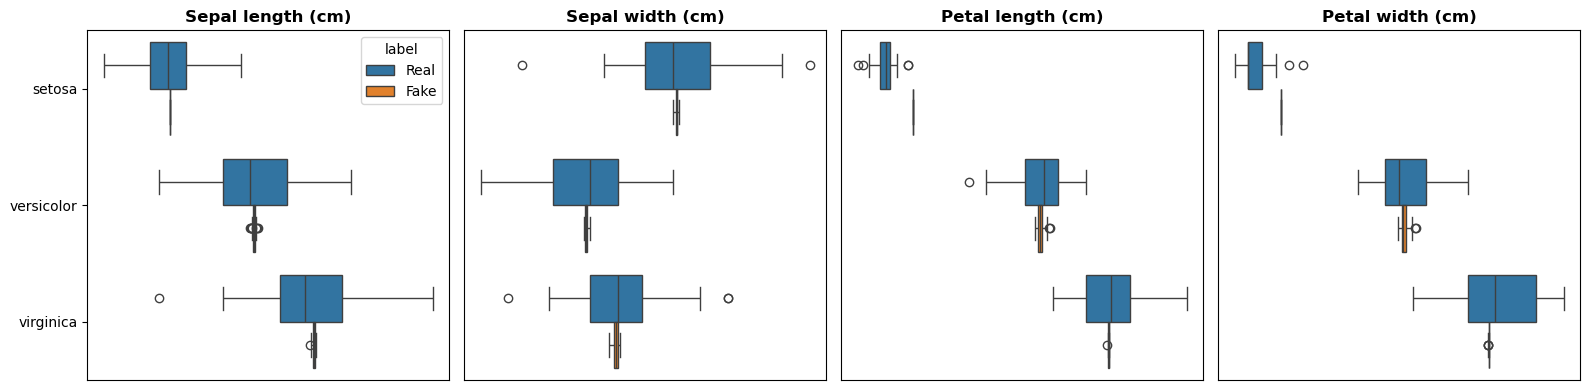

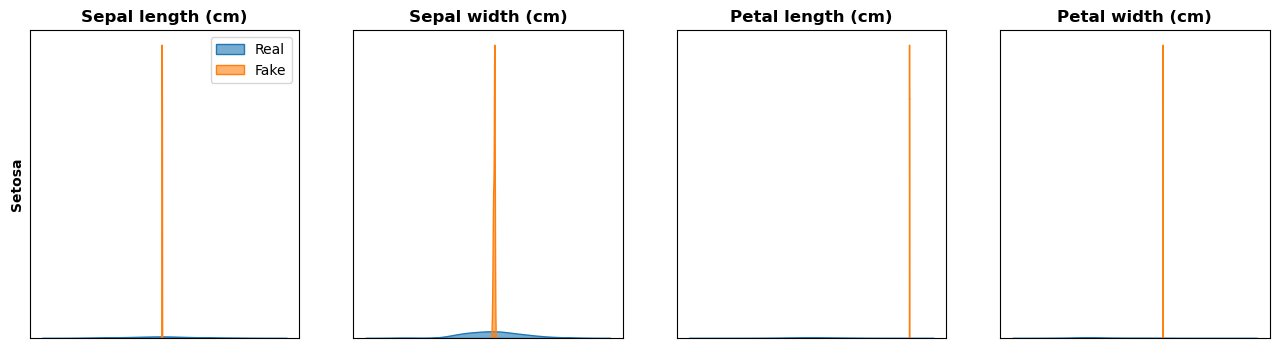

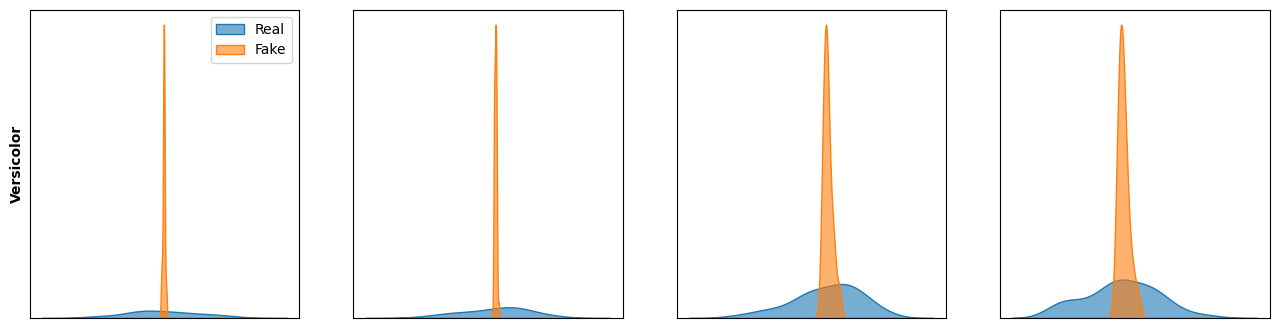

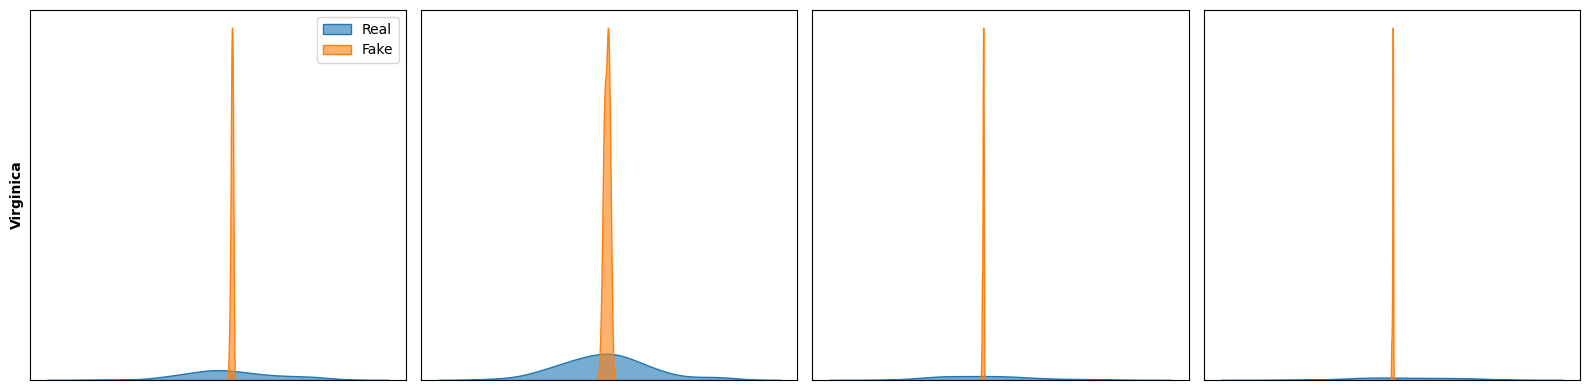

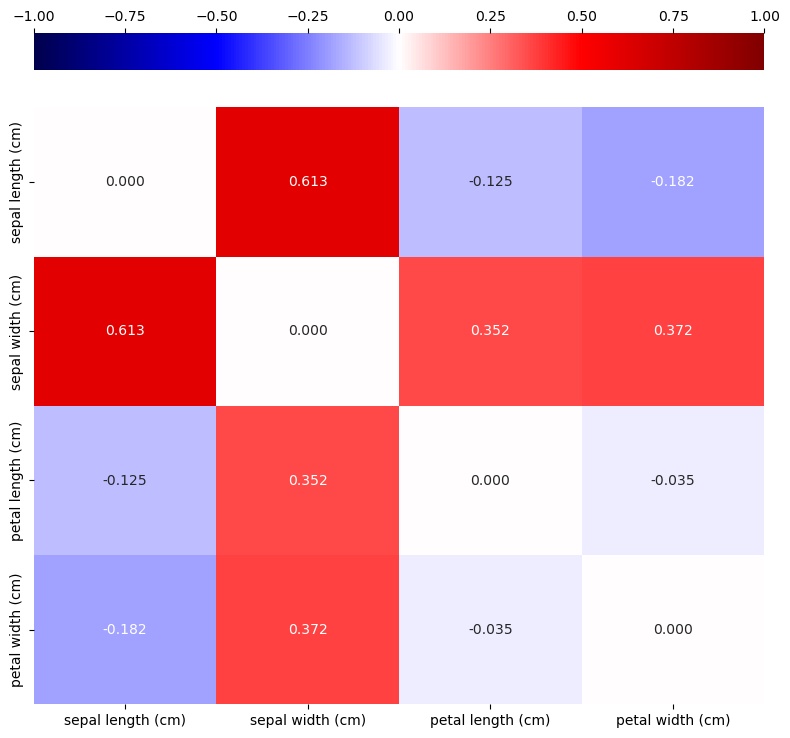

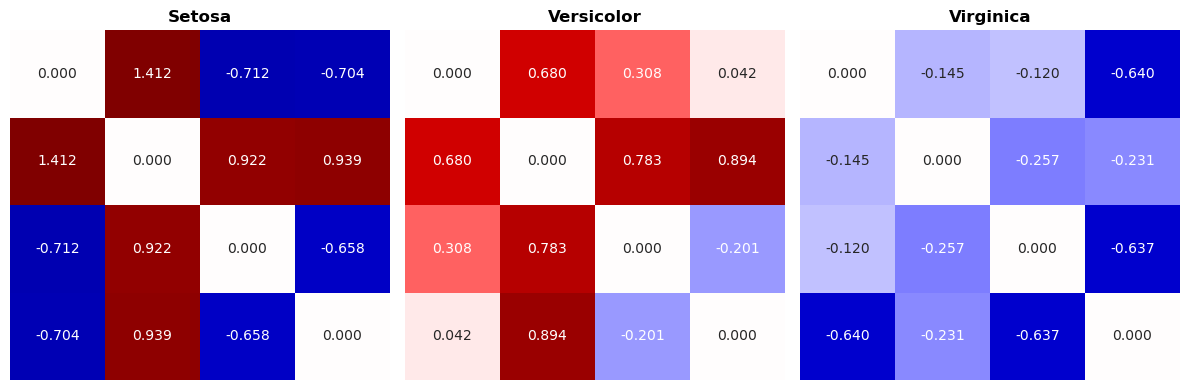

In [19]:
utils.plot_data(real_iris, 'target', vae_df)

Let's train the Conditional GAN.

In [20]:
g_opt = torch.optim.Adam(gen.parameters(), lr = 1e-3)
d_opt = torch.optim.Adam(disc.parameters(), lr = 1e-3)

criterion = nn.BCELoss()

set_seed()
z = torch.randn(150, 4)

In [21]:
for epoch in tqdm(range(501), desc = 'Training Conditional GAN'):
    
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    
    disc.train()
    gen.train()
    
    for data, labels in real_gan_dataloader:
        
        real_data = data
        real_labels = torch.ones(real_data.shape[0], 1)
        
        train_z = torch.randn(real_data.shape[0], 4)
        fake_data = gen(train_z, labels)
        fake_labels = torch.zeros(real_data.shape[0], 1)
        
        disc.zero_grad()
        
        real_loss = criterion(disc(real_data, labels), real_labels)
        fake_loss = criterion(disc(fake_data.detach(), labels), fake_labels)
        d_loss = (real_loss + fake_loss) / 2
        disc_epoch_loss += d_loss.item()
        d_loss.backward()
        
        d_opt.step()
        
        gen.zero_grad()
        
        gen_labels = torch.ones(real_data.shape[0], 1)
        
        g_loss = criterion(disc(fake_data, labels), gen_labels)
        gen_epoch_loss += g_loss.item()
        g_loss.backward()
        
        g_opt.step()
        
    g_epoch_loss = gen_epoch_loss/len(real_gan_dataloader)
    d_epoch_loss = disc_epoch_loss/len(real_gan_dataloader)
    
    if epoch % 50 == 0 or epoch == 500:
        
        print(f'\nEpoch {epoch}/500 | DLoss: {d_epoch_loss:.4f} | GLoss {g_epoch_loss:.4f}')
        with torch.no_grad():
            gen.eval()
            gen_z = gen(z, real_gan_dataloader.dataset.label)
            utils.compare_results(real_gan_dataloader.dataset.data, gen_z)

Training Conditional GAN:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 0/500 | DLoss: 0.7049 | GLoss 0.8255
MEAN: [ 0.033 -0.012 -0.096 -0.011]
STD:  [0.965 0.964 0.969 0.935]
MIN:  [-1.721 -2.333 -1.584 -1.283]
MAX:  [2.438 2.961 1.563 1.514]
SKEW: [ 0.531 -0.075 -0.764 -0.276]
KURT: [-0.946 -0.561 -2.841 -0.99 ]

Epoch 50/500 | DLoss: 0.5888 | GLoss 0.8638
MEAN: [ 0.557  0.92  -0.446  0.872]
STD:  [-0.344  0.691 -0.281 -0.597]
MIN:  [ 0.902 -0.659  0.23   2.   ]
MAX:  [ 0.734  3.539 -1.133 -0.258]
SKEW: [ 0.456  0.532  0.091 -0.045]
KURT: [ 0.819  0.773 -0.078  0.02 ]

Epoch 100/500 | DLoss: 0.6766 | GLoss 0.7381
MEAN: [ 1.178  0.847  0.444 -0.09 ]
STD:  [0.281 0.398 0.118 0.102]
MIN:  [ 1.076 -0.597  0.278 -0.11 ]
MAX:  [2.856 2.985 0.897 0.211]
SKEW: [ 0.985 -0.152  0.035  0.228]
KURT: [0.48  1.558 0.045 0.088]

Epoch 150/500 | DLoss: 0.6436 | GLoss 0.7290
MEAN: [-0.204 -0.344 -0.139 -0.034]
STD:  [0.21  0.322 0.206 0.044]
MIN:  [-0.881 -1.777 -0.463  0.096]
MAX:  [1.107 1.72  0.439 0.238]
SKEW: [0.704 0.386 0.174 0.238]
KURT: [0.893 1.644 0.06

In [22]:
gan_df = pd.DataFrame(std_scl.inverse_transform(gen_z.detach().numpy()))
gan_df['target'] = y
gan_df['target'] = gan_df['target'].map({i: species[i] for i in range(len(species))})
gan_df.columns = real_iris.columns

In [23]:
utils.describe_data(real_iris, 'target', gan_df)

REAL                      SYNTHETIC             \
                       setosa versicolor virginica    setosa versicolor   
MEAN sepal length (cm)  5.006      5.936     6.588     5.156      6.388   
     sepal width (cm)   3.428      2.770     2.974     3.603      2.918   
     petal length (cm)  1.462      4.260     5.552     0.604      5.056   
     petal width (cm)   0.246      1.326     2.026     0.093      1.735   
STD  sepal length (cm)  0.352      0.516     0.636     0.050      0.295   
     sepal width (cm)   0.379      0.314     0.322     0.100      0.078   
     petal length (cm)  0.174      0.470     0.552     0.271      0.362   
     petal width (cm)   0.105      0.198     0.275     0.098      0.150   
MIN  sepal length (cm)  4.300      4.900     4.900     5.043      6.083   
     sepal width (cm)   2.300      2.000     2.200     3.447      2.696   
     petal length (cm)  1.000      3.000     4.500    -0.039      4.616   
     petal width (cm)   0.100      1.000     1.400    -0.193      1.571   
MAX  sepal length (cm)  5.800      7.000     7.900     5.226      7.443   
     sepal width (cm)   4.400      3.400     3.800     3.825      3.093   
     petal length (cm)  1.900      5.100     6.900     0.972      6.372   
     petal width (cm)   0.600      1.800     2.500     0.218      2.324   
SKEW sepal length (cm)  0.116      0.102     0.114    -0.510      1.904   
     sepal width (cm)   0.040     -0.352     0.355     0.477     -0.581   
     petal length (cm)  0.103     -0.588     0.533    -0.712      1.686   
     petal width (cm)   1.216     -0.030    -0.126    -0.917      1.966   
KURT sepal length (cm) -0.346     -0.599    -0.088    -0.549      4.075   
     sepal width (cm)   0.744     -0.448     0.520    -0.690      0.719   
     petal length (cm)  0.805     -0.074    -0.256    -0.322      3.691   
     petal width (cm)   1.434     -0.488    -0.661     0.331      5.028   
IQR  sepal length (cm)  0.400      0.700     0.675     0.072      0.317   
     sepal width (cm)   0.475      0.475     0.375     0.153      0.083   
     petal length (cm)  0.175      0.600     0.775     0.370      0.458   
     petal width (cm)   0.100      0.300     0.500     0.122      0.184   

                                  
                       virginica  
MEAN sepal length (cm)     6.634  
     sepal width (cm)      3.000  
     petal length (cm)     5.799  
     petal width (cm)      1.985  
STD  sepal length (cm)     0.266  
     sepal width (cm)      0.089  
     petal length (cm)     0.441  
     petal width (cm)      0.204  
MIN  sepal length (cm)     6.258  
     sepal width (cm)      2.832  
     petal length (cm)     5.050  
     petal width (cm)      1.601  
MAX  sepal length (cm)     7.210  
     sepal width (cm)      3.202  
     petal length (cm)     6.779  
     petal width (cm)      2.444  
SKEW sepal length (cm)     0.578  
     sepal width (cm)      0.100  
     petal length (cm)     0.479  
     petal width (cm)      0.475  
KURT sepal length (cm)    -0.752  
     sepal width (cm)     -0.357  
     petal length (cm)    -0.535  
     petal width (cm)     -0.407  
IQR  sepal length (cm)     0.406  
     sepal width (cm)      0.104  
     petal length (cm)     0.645  
     petal width (cm)      0.268

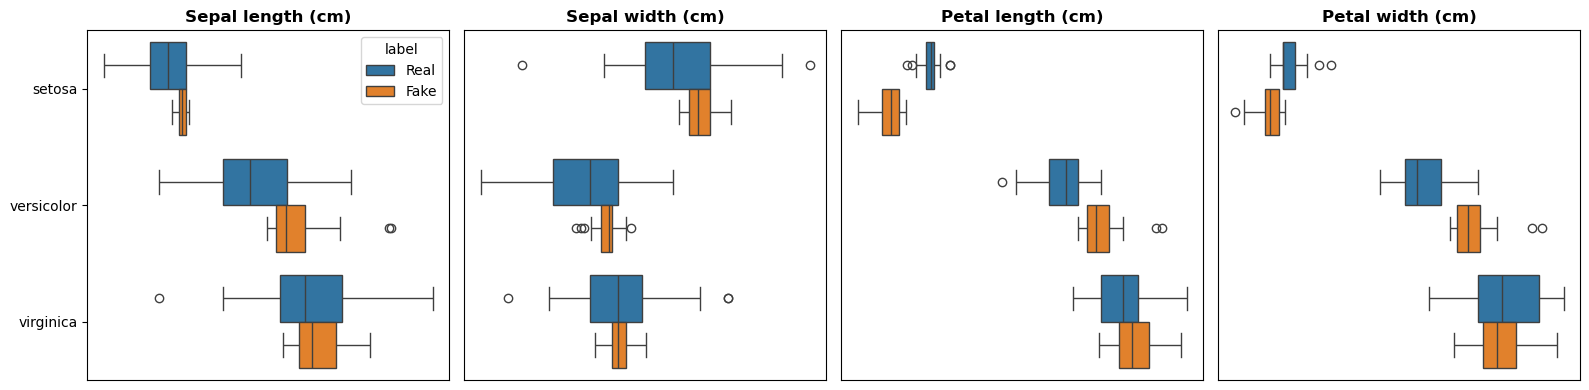

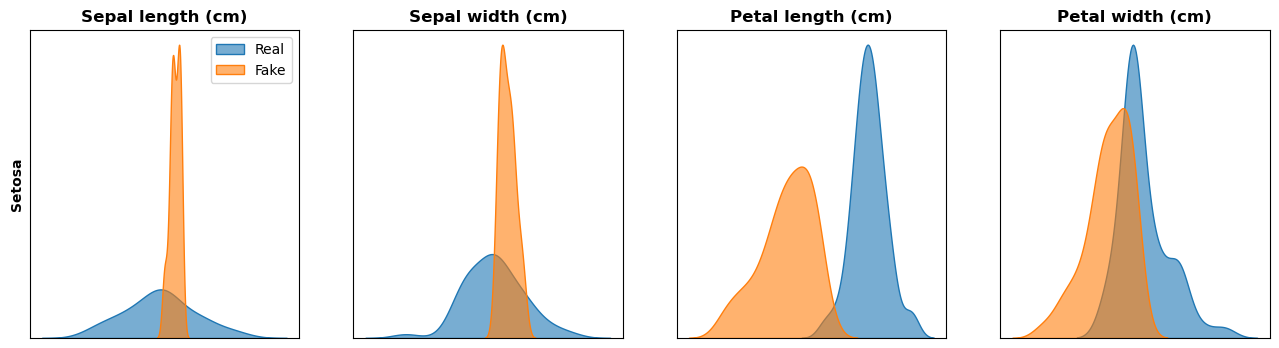

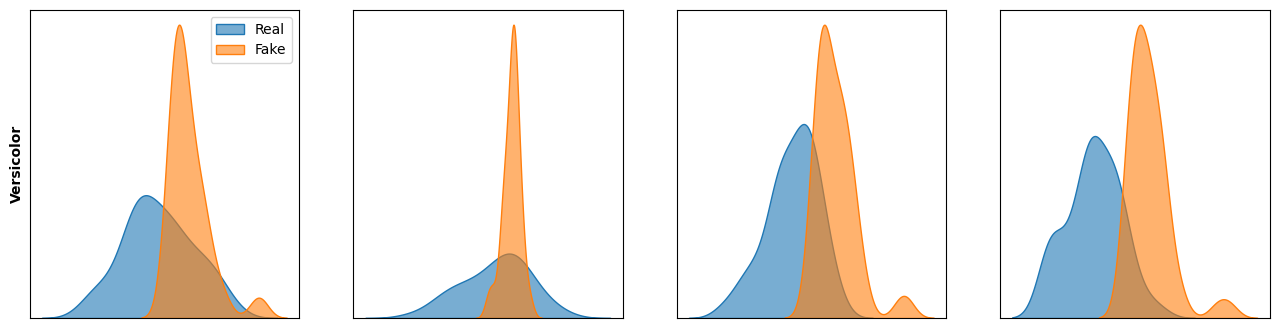

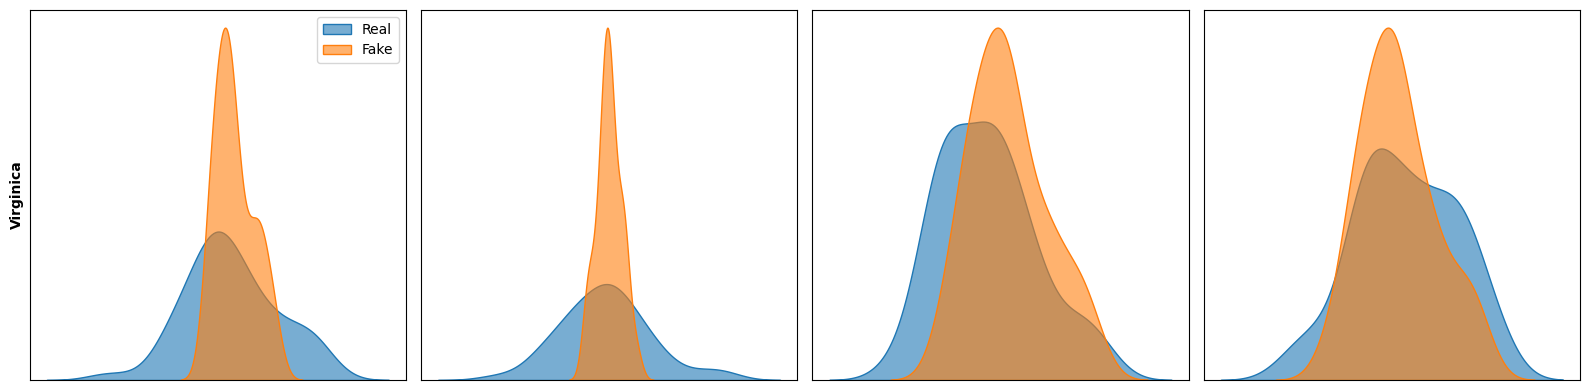

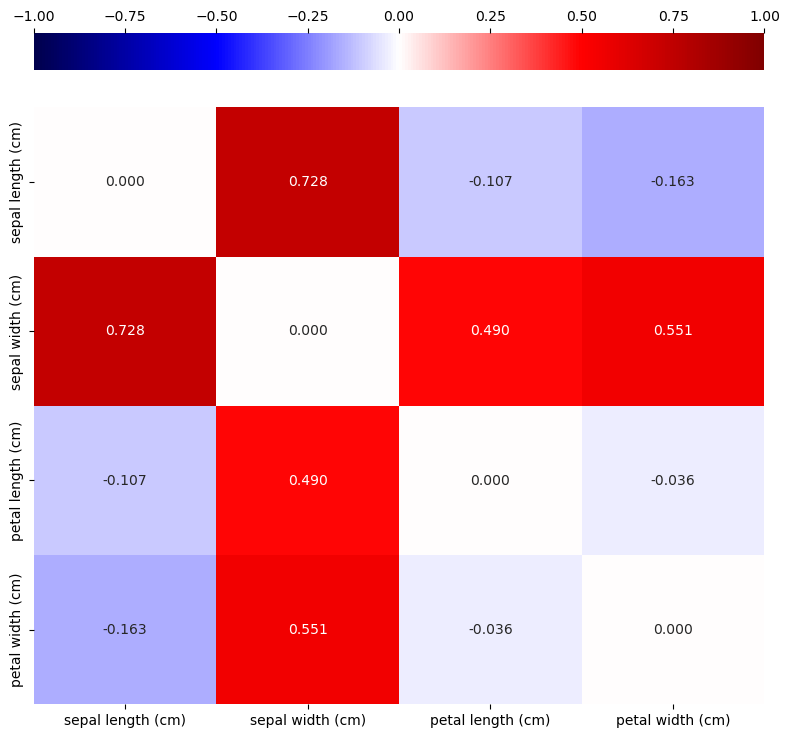

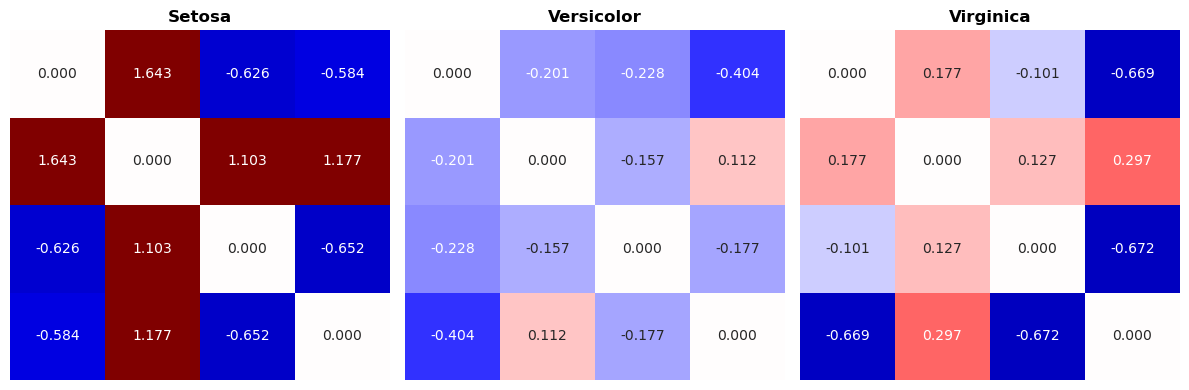

In [24]:
utils.plot_data(real_iris, 'target', gan_df)

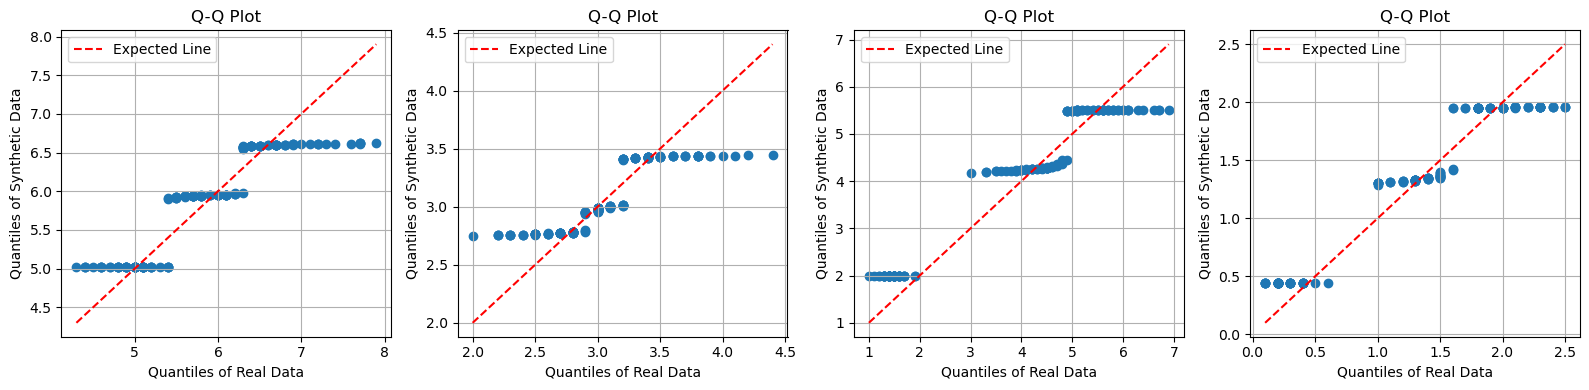

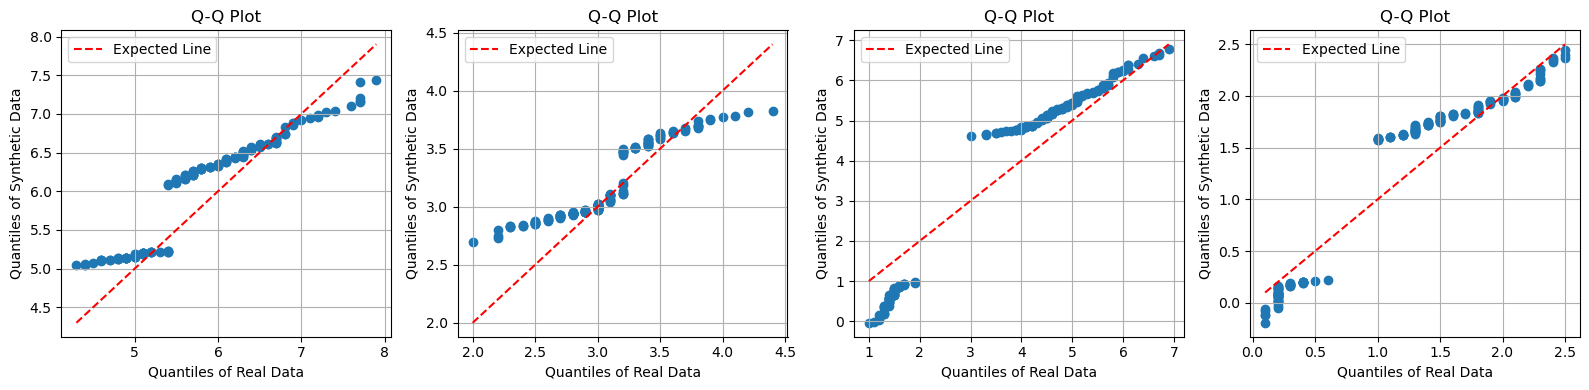

In [25]:
utils.plot_quantiles(real_iris, vae_df)
utils.plot_quantiles(real_iris, gan_df)

In [26]:
print((real_iris.select_dtypes('number').corr() - vae_df.select_dtypes('number').corr()).sum().sum())
print((real_iris.select_dtypes('number').corr() - gan_df.select_dtypes('number').corr()).sum().sum())

1.9909988839882367
2.9274057862077054


The performance of the models is clear: using Q-Q plots we see that the data generated with the simpler GAN show better overlap with the actual data. We will follow this path.

## Conditional Generative Adversarial Network

In this section, we focus on refining the GAN architecture to maximize its performance in generating synthetic data that closely resembles the real dataset. Our aim is to improve the overlap between the distributions of generated and real data while maintaining computational efficiency. The resulting model will form the basis for subsequent evaluations and applications.

The strating point is a model with 861 parameters. We'll build other 2 bigger versions to prove out which is the best.

In [27]:
# Smallest GAN

class Generator1(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 4),
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x
    
class Discriminator1(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
            
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x

# Medium GAN

class Generator2(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 4),
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x
    
class Discriminator2(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
            
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x

# Big GAN

class Generator3(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 4),
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x
    
class Discriminator3(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
            
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x
    
set_seed()    
small_gan_gen = Generator1(input_dim = 4, num_classes = 3)
small_gan_disc = Discriminator1(input_dim = 4, num_classes = 3)

med_gan_gen = Generator2(input_dim = 4, num_classes = 3)
med_gan_disc = Discriminator2(input_dim = 4, num_classes = 3)

big_gan_gen = Generator3(input_dim = 4, num_classes = 3)
big_gan_disc = Discriminator3(input_dim = 4, num_classes = 3)

small_gan = {'Generator':small_gan_gen, 'Discriminator':small_gan_disc}

med_gan = {'Generator':med_gan_gen, 'Discriminator':med_gan_disc}

big_gan = {'Generator':big_gan_gen, 'Discriminator':big_gan_disc}

In [28]:
for size in [small_gan, med_gan, big_gan]:
    for model in size:
        print(f'{model} parameters: {sum(p.numel() for p in size[model].parameters())/1000}k')

Generator parameters: 0.861k
Discriminator parameters: 0.81k
Generator parameters: 3.197k
Discriminator parameters: 3.146k
Generator parameters: 11.965k
Discriminator parameters: 11.914k


The 3 models have a very different number of parameters. Next step is to set the optimized ones and start training.

In [29]:
small_gan['Generator optimizer'] = torch.optim.Adam(small_gan_gen.parameters(), lr = 1e-3)
small_gan['Discriminator optimizer'] = torch.optim.Adam(small_gan_disc.parameters(), lr = 1e-3)

med_gan['Generator optimizer'] = torch.optim.Adam(med_gan_gen.parameters(), lr = 1e-3)
med_gan['Discriminator optimizer'] = torch.optim.Adam(med_gan_disc.parameters(), lr = 1e-3)

big_gan['Generator optimizer'] = torch.optim.Adam(big_gan_gen.parameters(), lr = 1e-3)
big_gan['Discriminator optimizer'] = torch.optim.Adam(big_gan_disc.parameters(), lr = 1e-3)

criterion = nn.BCELoss()

set_seed()
z = torch.randn(150, 4)

In [30]:
for idx, size in enumerate([small_gan, med_gan, big_gan]):
    
    for epoch in tqdm(range(501), desc = f'Training Conditional GAN {idx + 1}'):
        
        gen = size['Generator']
        disc = size['Discriminator']
        g_opt = size['Generator optimizer']
        d_opt = size['Discriminator optimizer']
        
        gen_epoch_loss = 0
        disc_epoch_loss = 0
    
        disc.train()
        gen.train()
        
        for data, labels in real_gan_dataloader:
            
            real_data = data
            real_labels = torch.ones(real_data.shape[0], 1)
        
            train_z = torch.randn(real_data.shape[0], 4)
            fake_data = gen(train_z, labels)
            fake_labels = torch.zeros(real_data.shape[0], 1)
        
            disc.zero_grad()
            
            real_loss = criterion(disc(real_data, labels), real_labels)
            fake_loss = criterion(disc(fake_data.detach(), labels), fake_labels)
            d_loss = (real_loss + fake_loss) / 2
            disc_epoch_loss += d_loss.item()
            d_loss.backward()
        
            d_opt.step()
        
            gen.zero_grad()
        
            gen_labels = torch.ones(real_data.shape[0], 1)
        
            g_loss = criterion(disc(fake_data, labels), gen_labels)
            gen_epoch_loss += g_loss.item()
            g_loss.backward()
        
            g_opt.step()
            
        g_epoch_loss = gen_epoch_loss/len(real_gan_dataloader)
        d_epoch_loss = disc_epoch_loss/len(real_gan_dataloader)
        
        if epoch % 100 == 0 or epoch == 500:
        
            print(f'\nEpoch {epoch}/500 | DLoss: {d_epoch_loss:.4f} | GLoss {g_epoch_loss:.4f}')
            with torch.no_grad():
                gen.eval()
                gen_z = gen(z, real_gan_dataloader.dataset.label)
                utils.compare_results(real_gan_dataloader.dataset.data, gen_z)

Training Conditional GAN 1:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 0/500 | DLoss: 0.7049 | GLoss 0.8255
MEAN: [ 0.033 -0.012 -0.096 -0.011]
STD:  [0.965 0.964 0.969 0.935]
MIN:  [-1.721 -2.333 -1.584 -1.283]
MAX:  [2.438 2.961 1.563 1.514]
SKEW: [ 0.531 -0.075 -0.764 -0.276]
KURT: [-0.946 -0.561 -2.841 -0.99 ]

Epoch 100/500 | DLoss: 0.6766 | GLoss 0.7381
MEAN: [ 1.178  0.847  0.444 -0.09 ]
STD:  [0.281 0.398 0.118 0.102]
MIN:  [ 1.076 -0.597  0.278 -0.11 ]
MAX:  [2.856 2.985 0.897 0.211]
SKEW: [ 0.985 -0.152  0.035  0.228]
KURT: [0.48  1.558 0.045 0.088]

Epoch 200/500 | DLoss: 0.7312 | GLoss 0.6434
MEAN: [ 0.032 -0.386 -0.037 -0.121]
STD:  [ 0.147  0.315  0.119 -0.063]
MIN:  [-0.763 -1.7   -0.207 -0.03 ]
MAX:  [ 1.062  1.716  0.37  -0.073]
SKEW: [-0.217  0.858 -0.129 -0.168]
KURT: [0.87  1.638 0.069 0.152]

Epoch 300/500 | DLoss: 0.6807 | GLoss 0.7064
MEAN: [ 0.41  -0.046 -0.049 -0.151]
STD:  [0.234 0.235 0.136 0.043]
MIN:  [-0.19  -1.107 -0.176 -0.094]
MAX:  [1.713 1.681 0.518 0.068]
SKEW: [ 0.584 -0.189  0.305  0.292]
KURT: [0.878 1.544 0.0

Training Conditional GAN 2:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 0/500 | DLoss: 0.6951 | GLoss 0.8095
MEAN: [-0.173  0.142 -0.191  0.029]
STD:  [0.972 0.97  0.977 0.962]
MIN:  [-1.981 -2.232 -1.703 -1.272]
MAX:  [2.211 3.183 1.539 1.67 ]
SKEW: [-0.309  0.787  0.186  0.757]
KURT: [-0.94   1.437 -0.69  -2.501]

Epoch 100/500 | DLoss: 0.5758 | GLoss 1.0313
MEAN: [-0.521 -1.036  0.353 -0.13 ]
STD:  [ 0.157  0.191 -0.414  0.143]
MIN:  [-1.272 -2.518  0.957 -0.308]
MAX:  [0.046 0.65  0.032 0.208]
SKEW: [ 0.337 -0.299  0.262  0.413]
KURT: [0.529 1.637 0.063 0.106]

Epoch 200/500 | DLoss: 0.6027 | GLoss 1.4536
MEAN: [-0.095  0.765 -0.056 -0.335]
STD:  [0.773 0.845 0.979 0.742]
MIN:  [-1.658 -1.15  -1.508 -1.498]
MAX:  [1.661 3.51  1.688 0.429]
SKEW: [-0.628  0.293  1.119 -0.934]
KURT: [-0.258  0.19  -4.367 -1.363]

Epoch 300/500 | DLoss: 0.5000 | GLoss 0.9699
MEAN: [ 0.105 -0.514  0.206  0.069]
STD:  [-0.038  0.593 -0.102 -0.032]
MIN:  [-0.282 -2.29   0.242  0.09 ]
MAX:  [1.052 2.041 0.462 0.082]
SKEW: [0.523 0.723 0.089 0.115]
KURT: [0.904 1.655 0.0

Training Conditional GAN 3:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 0/500 | DLoss: 0.6879 | GLoss 0.6823
MEAN: [-0.    -0.247  0.18   0.336]
STD:  [0.989 0.997 0.977 0.982]
MIN:  [-1.844 -2.661 -1.313 -1.037]
MAX:  [2.442 2.829 1.922 2.005]
SKEW: [-0.412  0.768  0.205 -0.053]
KURT: [-0.834 -0.129 -1.165 -1.465]

Epoch 100/500 | DLoss: 0.4969 | GLoss 1.1421
MEAN: [-0.923 -0.247  0.19  -0.696]
STD:  [ 0.228  0.124 -0.331 -0.549]
MIN:  [-2.009 -1.546  0.548 -0.267]
MAX:  [-1.122  1.522 -0.281 -3.067]
SKEW: [-0.735 -0.308  0.182 -0.334]
KURT: [-0.593  1.667  0.058 -0.263]

Epoch 200/500 | DLoss: 0.5317 | GLoss 1.2669
MEAN: [-0.7   -1.711 -0.118  0.245]
STD:  [-0.546  0.32  -0.49   0.239]
MIN:  [-0.491 -2.963  0.495 -0.056]
MAX:  [-0.867  0.161 -0.418  1.005]
SKEW: [0.47  0.934 0.181 0.457]
KURT: [0.883 1.5   0.086 0.148]

Epoch 300/500 | DLoss: 0.5168 | GLoss 0.9491
MEAN: [0.391 0.265 0.224 0.313]
STD:  [0.402 0.072 0.734 0.62 ]
MIN:  [-0.502 -1.142 -0.902 -0.52 ]
MAX:  [2.269 1.929 1.607 1.476]
SKEW: [ 0.97  -0.347  0.018  0.233]
KURT: [ 0.896  1.6

Great! Now we can compare the results to choose the best architecture.

In [31]:
gen1_z = small_gan['Generator'](z, real_gan_dataloader.dataset.label)
gen2_z = med_gan['Generator'](z, real_gan_dataloader.dataset.label)
gen3_z = big_gan['Generator'](z, real_gan_dataloader.dataset.label)

In [32]:
gan1_df = pd.DataFrame(std_scl.inverse_transform(gen1_z.detach().numpy()))
gan1_df['target'] = y
gan1_df['target'] = gan1_df['target'].map({i: species[i] for i in range(len(species))})
gan1_df.columns = real_iris.columns

gan2_df = pd.DataFrame(std_scl.inverse_transform(gen2_z.detach().numpy()))
gan2_df['target'] = y
gan2_df['target'] = gan2_df['target'].map({i: species[i] for i in range(len(species))})
gan2_df.columns = real_iris.columns

gan3_df = pd.DataFrame(std_scl.inverse_transform(gen3_z.detach().numpy()))
gan3_df['target'] = y
gan3_df['target'] = gan3_df['target'].map({i: species[i] for i in range(len(species))})
gan3_df.columns = real_iris.columns

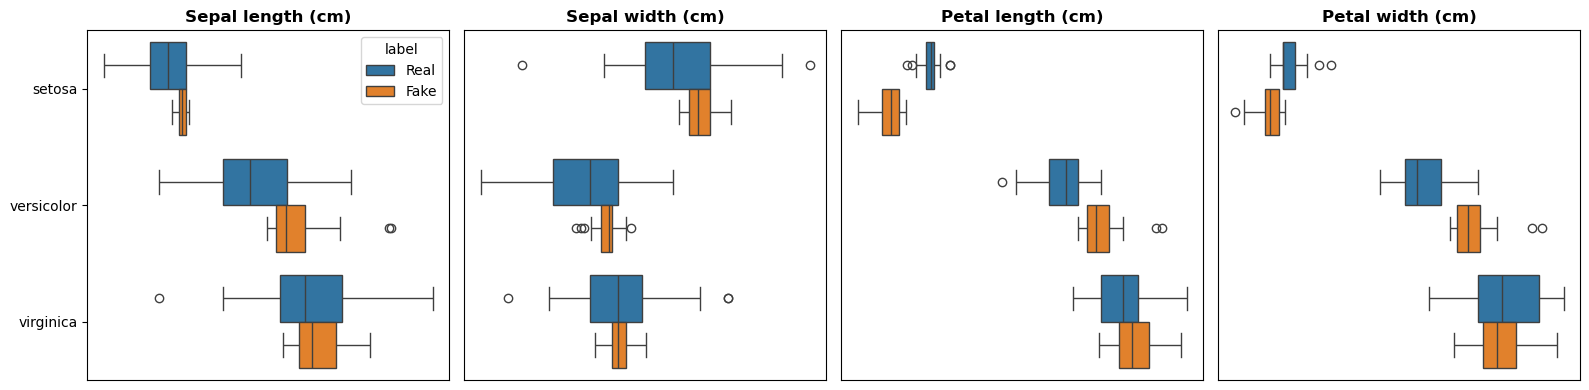

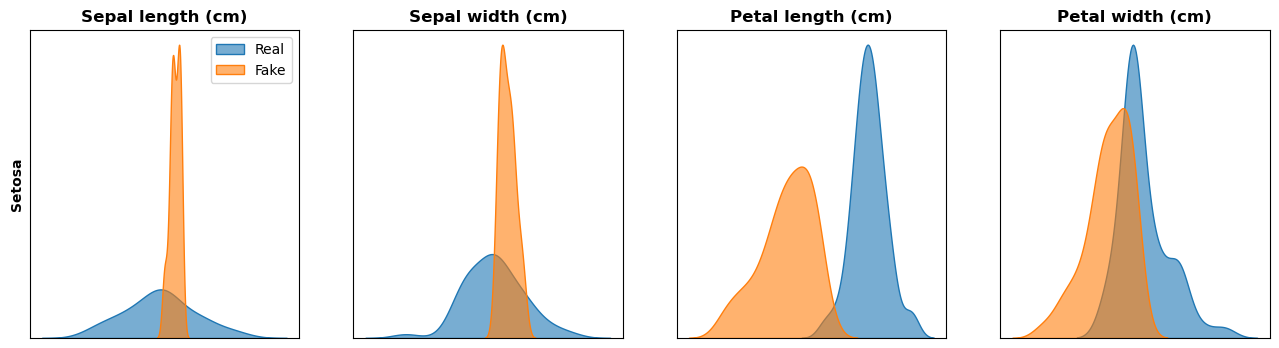

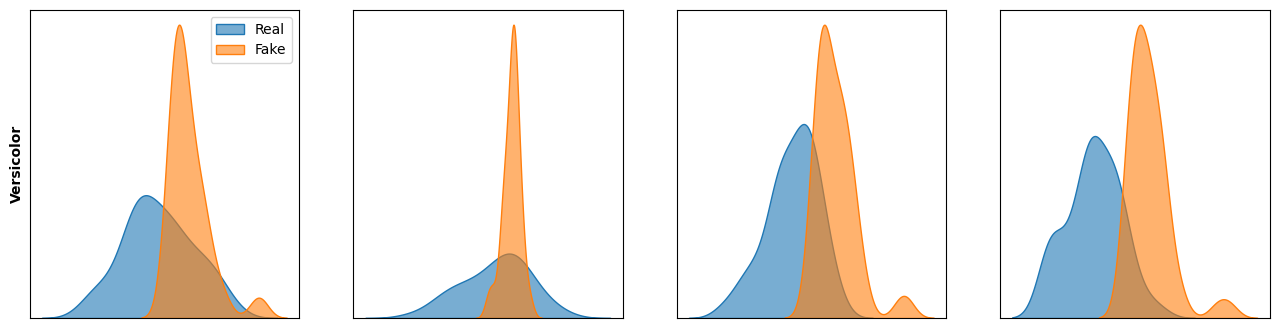

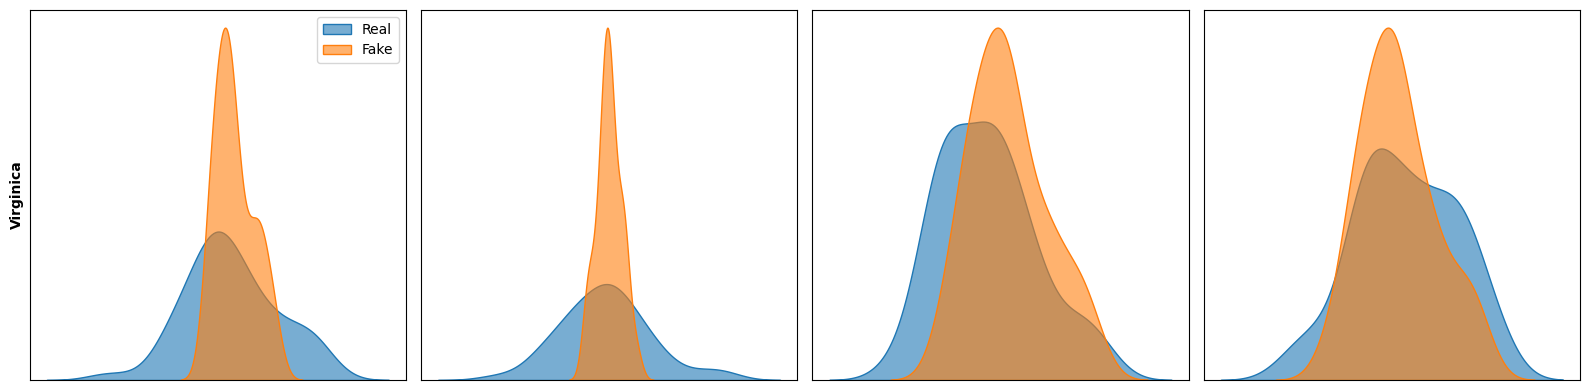

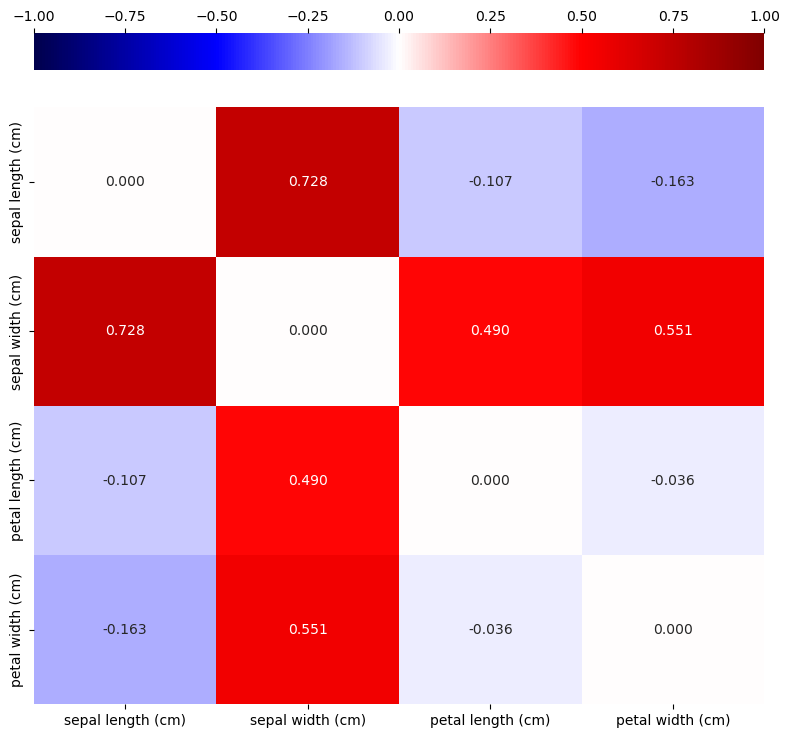

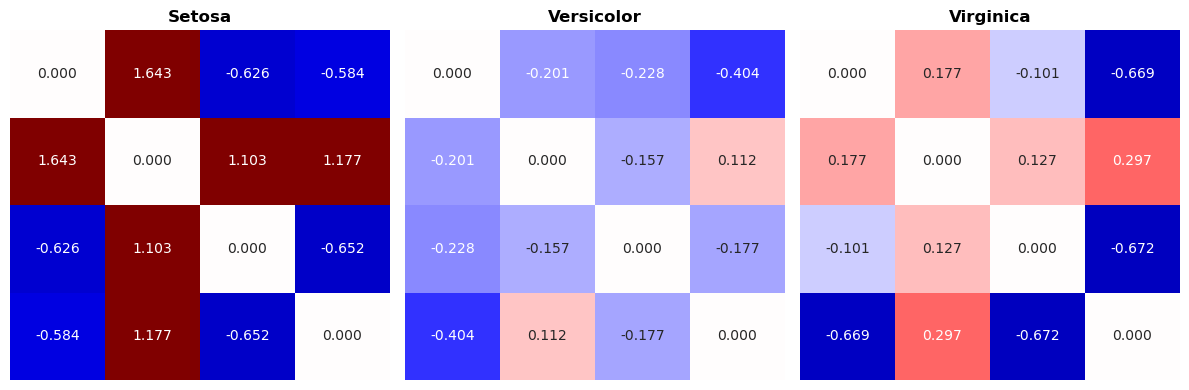

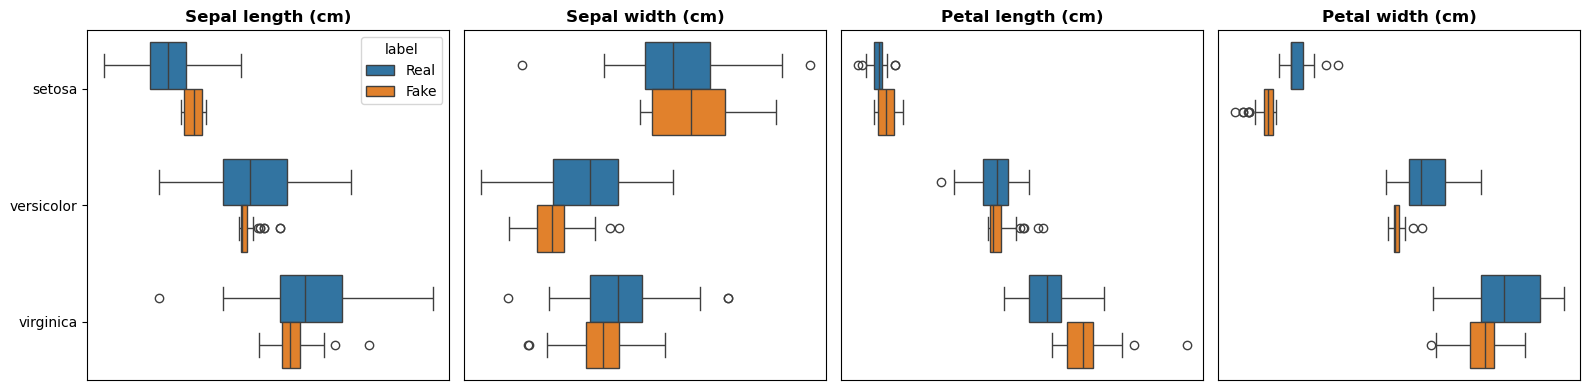

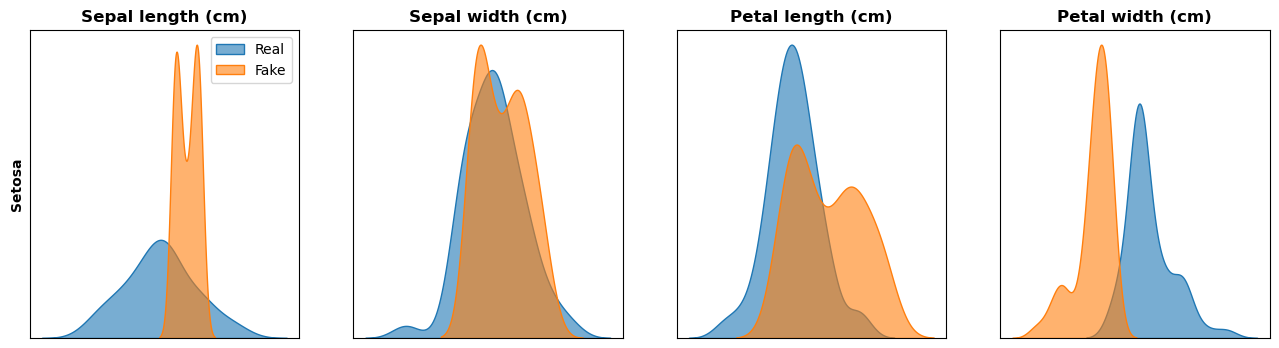

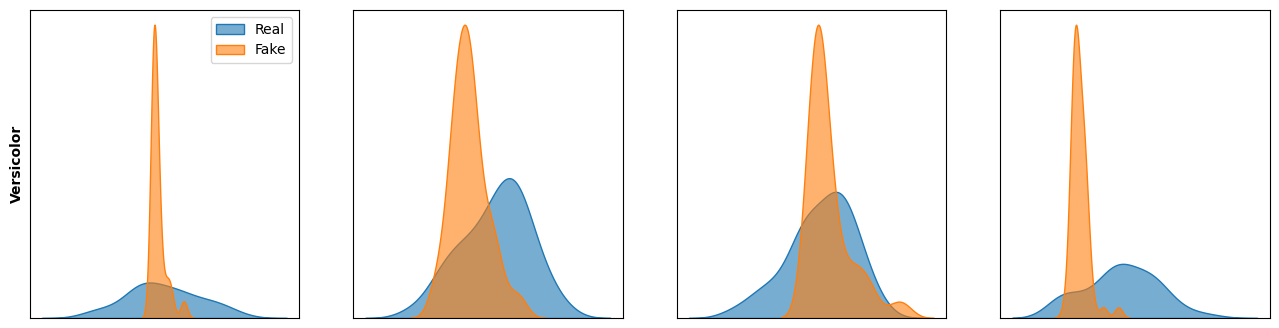

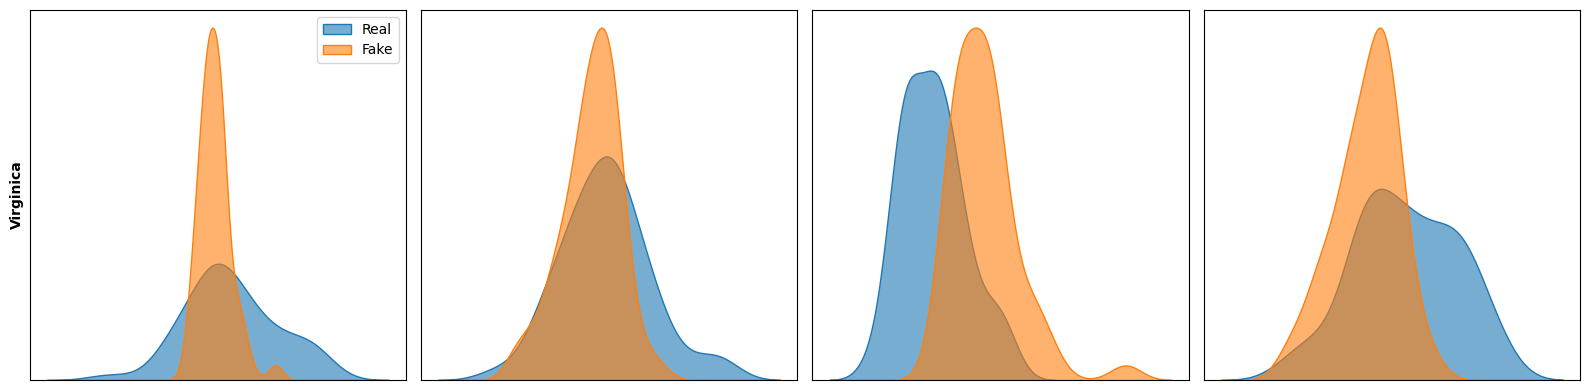

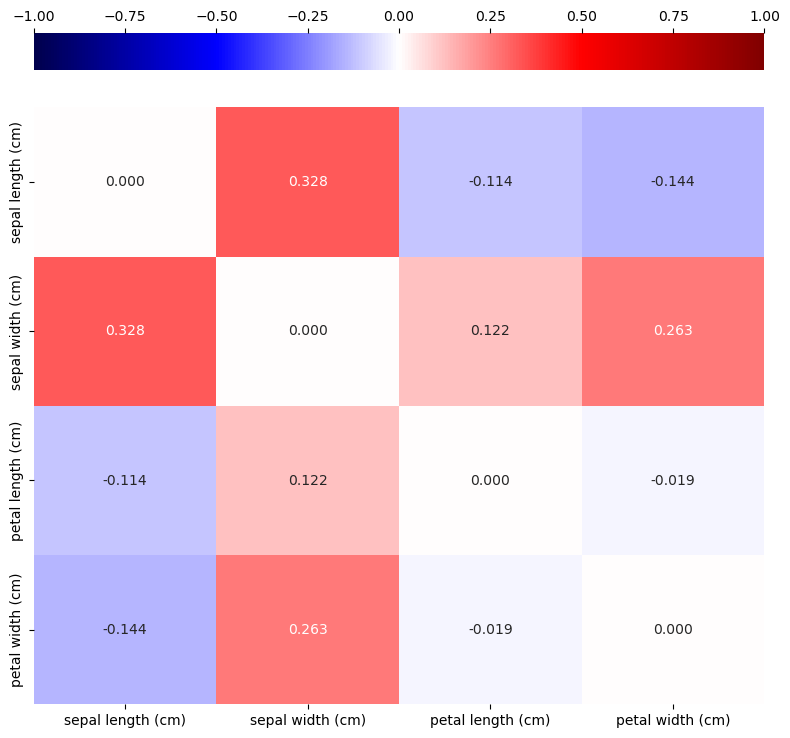

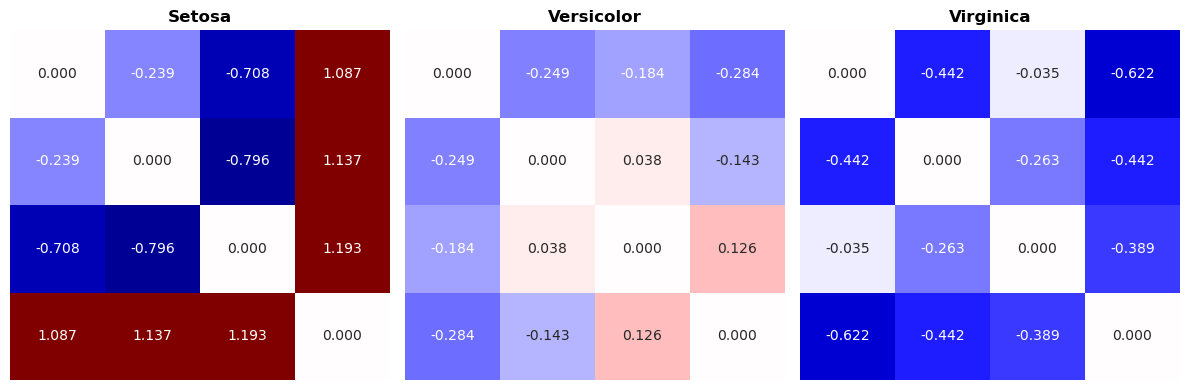

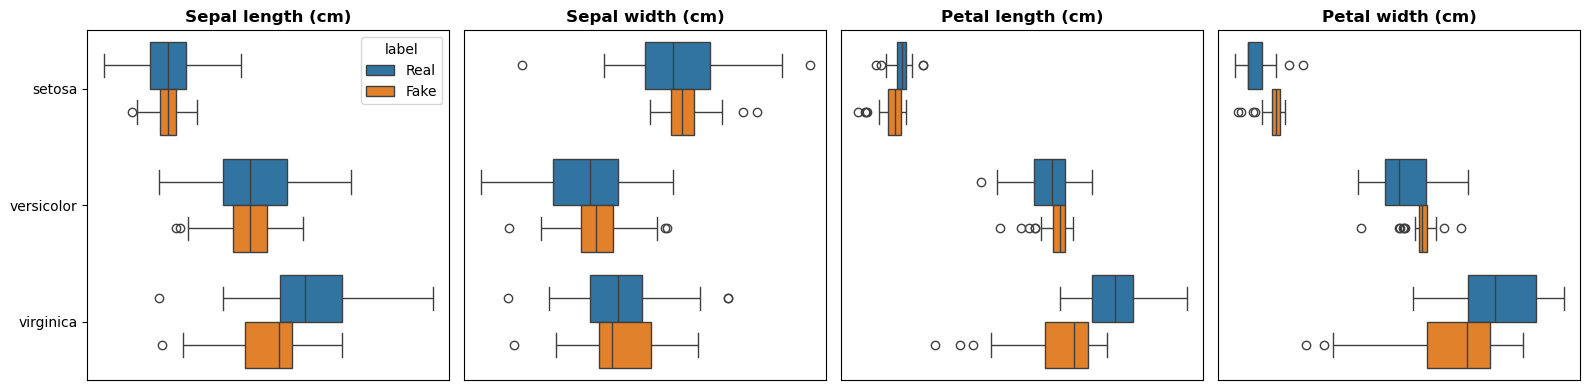

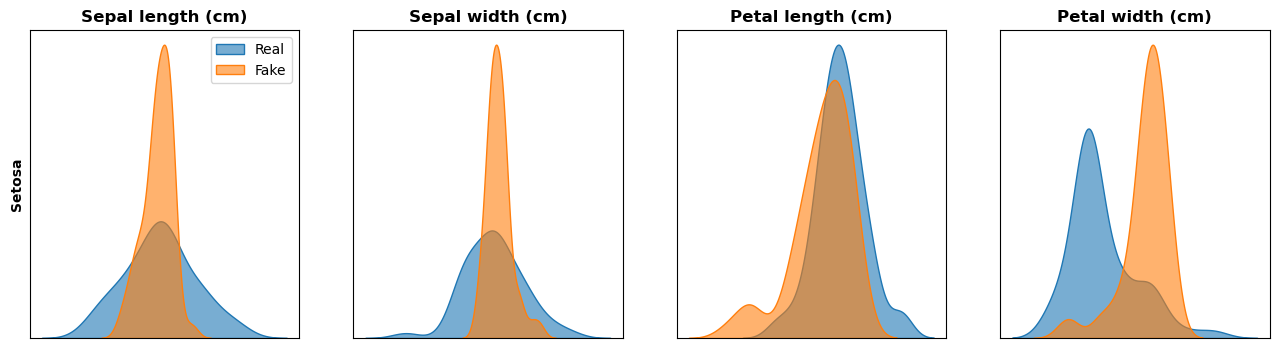

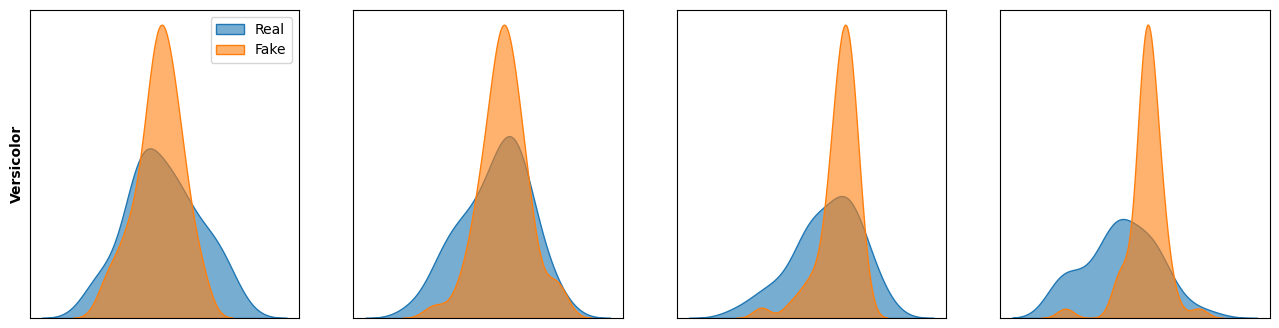

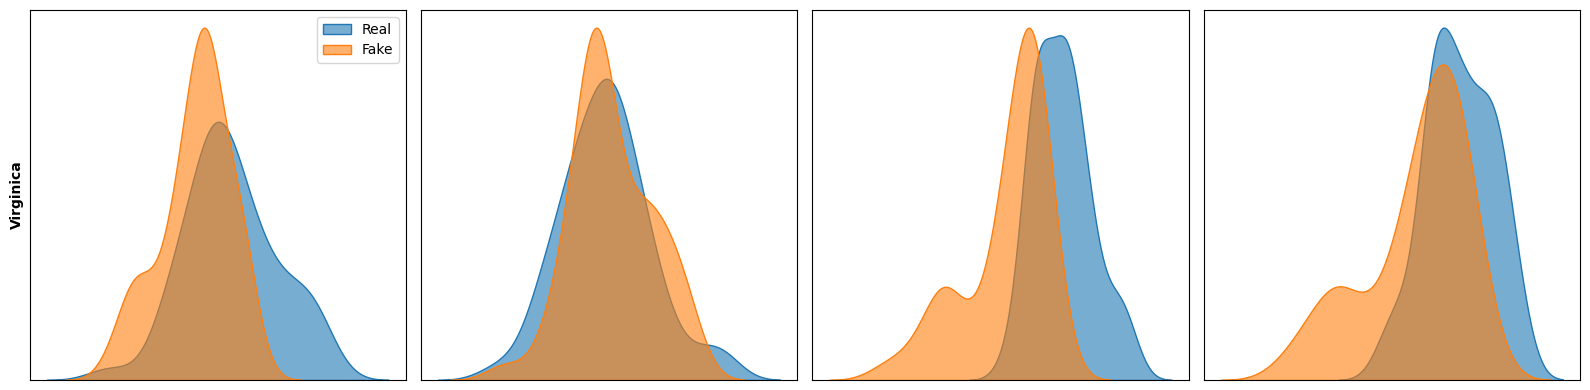

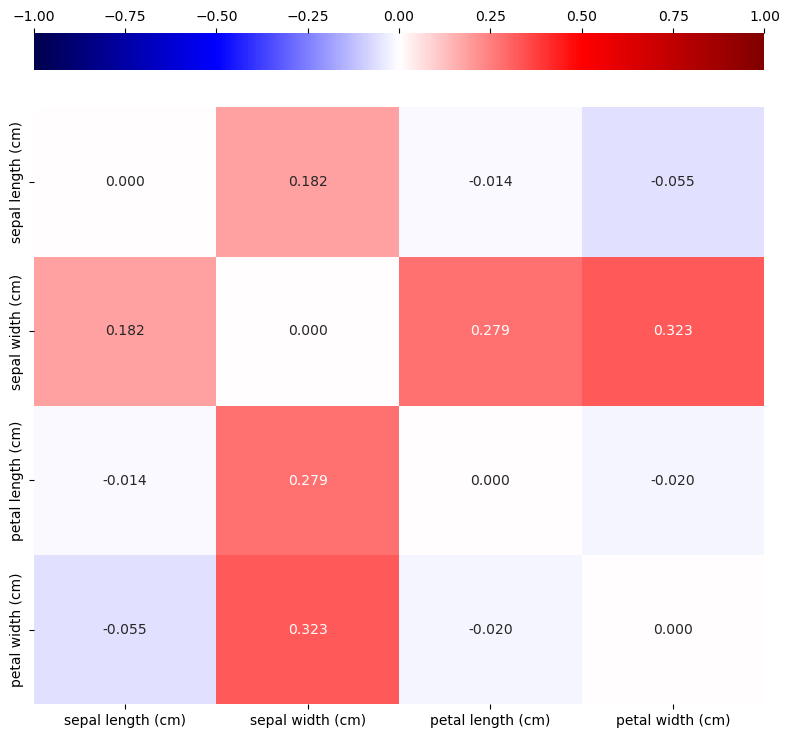

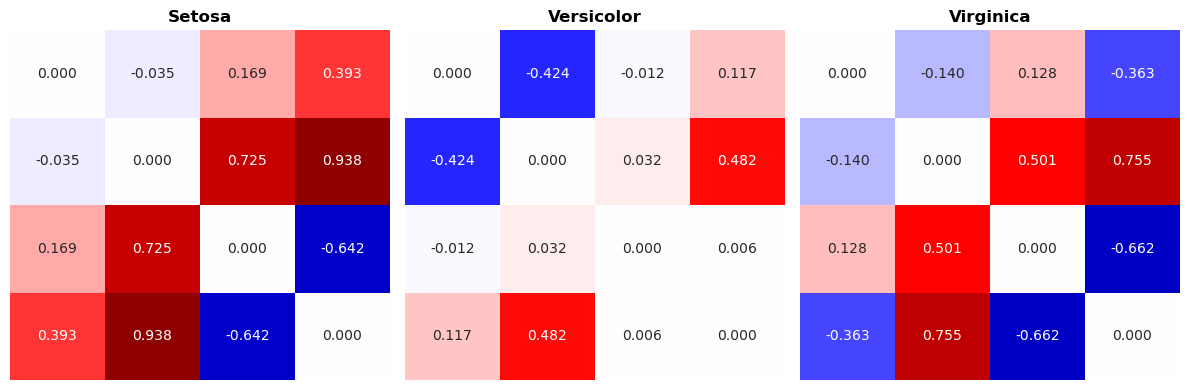

In [33]:
utils.plot_data(real_iris, 'target', gan1_df)
utils.plot_data(real_iris, 'target', gan2_df)
utils.plot_data(real_iris, 'target', gan3_df)

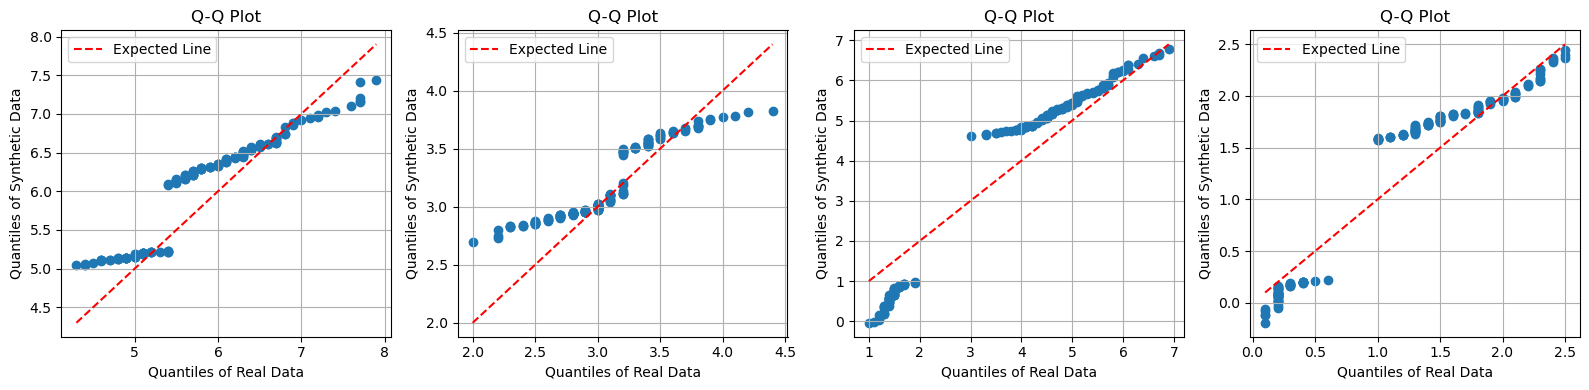

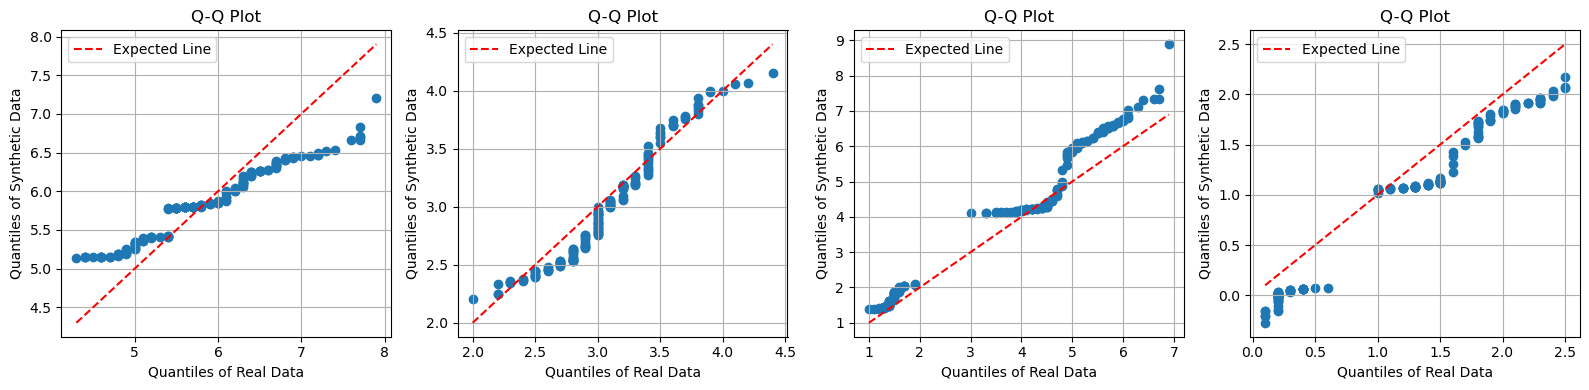

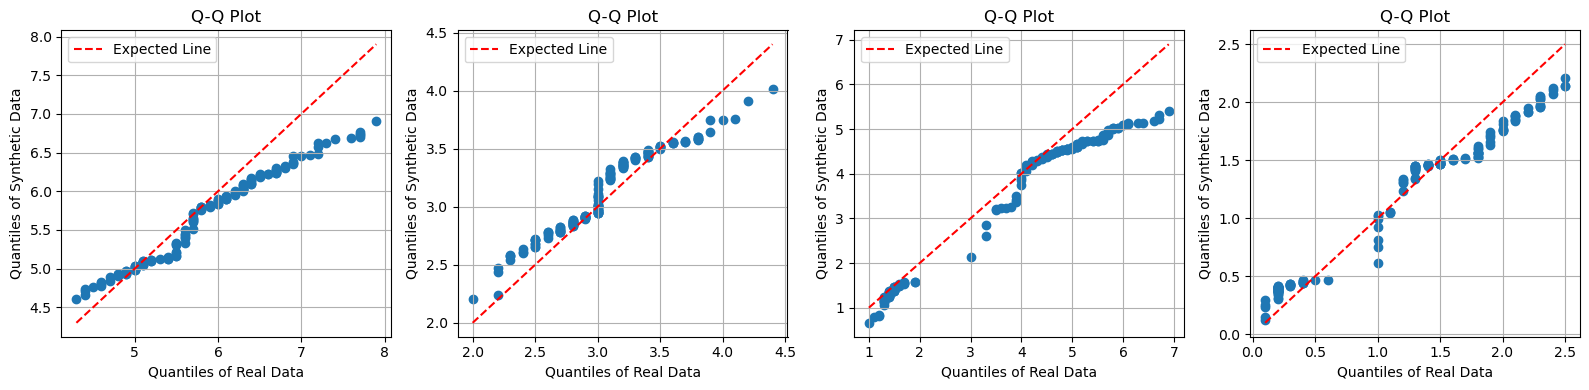

In [34]:
utils.plot_quantiles(real_iris, gan1_df)
utils.plot_quantiles(real_iris, gan2_df)
utils.plot_quantiles(real_iris, gan3_df)

In [35]:
print((real_iris.select_dtypes('number').corr().sum() - gan1_df.select_dtypes('number').corr().sum()).sum())
print((real_iris.select_dtypes('number').corr().sum() - gan2_df.select_dtypes('number').corr().sum()).sum())
print((real_iris.select_dtypes('number').corr().sum() - gan3_df.select_dtypes('number').corr().sum()).sum())

2.9274057862077063
0.8732084795696549
1.3892826438945372


Overall, for the same noise vector size, it is the intermediate model that shows the best performance: in fact, it produces the smallest differences between the observed and recreated correlations, in the Q-Q graphs it can be seen that the two distributions tend to overlap more than in the other two models, and the reproduced univariate distributions also overlap more. 

We will continue with the fine-tuning of this architecture. But first we will look for the best dimension of the noise vector.

In [36]:
noise_size = [2**n for n in range(1, 10)]

noise_vector_model_dict = {'Noise Vector Size':[], 'Gen state dict': []}

for size_idx, size in enumerate(noise_size):
    
    set_seed()
    gen = Generator2(input_dim = size, num_classes = 3)
    disc = Discriminator2(input_dim = 4, num_classes = 3)
    
    g_opt = torch.optim.Adam(gen.parameters(), lr = 1e-3)
    d_opt = torch.optim.Adam(disc.parameters(), lr = 1e-3)

    criterion = nn.BCELoss()
    
    for epoch in tqdm(range(501), desc = f'Training with {size} noise vector'):
    
        gen_epoch_loss = 0
        disc_epoch_loss = 0

        disc.train()
        gen.train()
        
        for data, labels in real_gan_dataloader:
            real_data = data
            real_labels = torch.ones(real_data.shape[0], 1)
            
            set_seed(epoch)
            train_z = torch.randn(real_data.shape[0], size)
            fake_data = gen(train_z, labels)
            fake_labels = torch.zeros(real_data.shape[0], 1)
        
            disc.zero_grad()
            
            real_loss = criterion(disc(real_data, labels), real_labels)
            fake_loss = criterion(disc(fake_data.detach(), labels), fake_labels)
            d_loss = (real_loss + fake_loss) / 2
            disc_epoch_loss += d_loss.item()
            d_loss.backward()
            
            d_opt.step()
        
            gen.zero_grad()

            gen_labels = torch.ones(real_data.shape[0], 1)

            g_loss = criterion(disc(fake_data, labels), gen_labels)
            gen_epoch_loss += g_loss.item()
            g_loss.backward()

            g_opt.step()
            
        g_epoch_loss = gen_epoch_loss/len(real_gan_dataloader)
        d_epoch_loss = disc_epoch_loss/len(real_gan_dataloader)
    
    noise_vector_model_dict['Noise Vector Size'].append(size)
    noise_vector_model_dict['Gen state dict'].append(gen.state_dict())

Training with 2 noise vector:   0%|          | 0/501 [00:00<?, ?it/s]

Training with 4 noise vector:   0%|          | 0/501 [00:00<?, ?it/s]

Training with 8 noise vector:   0%|          | 0/501 [00:00<?, ?it/s]

Training with 16 noise vector:   0%|          | 0/501 [00:00<?, ?it/s]

Training with 32 noise vector:   0%|          | 0/501 [00:00<?, ?it/s]

Training with 64 noise vector:   0%|          | 0/501 [00:00<?, ?it/s]

Training with 128 noise vector:   0%|          | 0/501 [00:00<?, ?it/s]

Training with 256 noise vector:   0%|          | 0/501 [00:00<?, ?it/s]

Training with 512 noise vector:   0%|          | 0/501 [00:00<?, ?it/s]

Great! We will now check only those models that show a total difference between the actual and recreated correlations of less than 1.

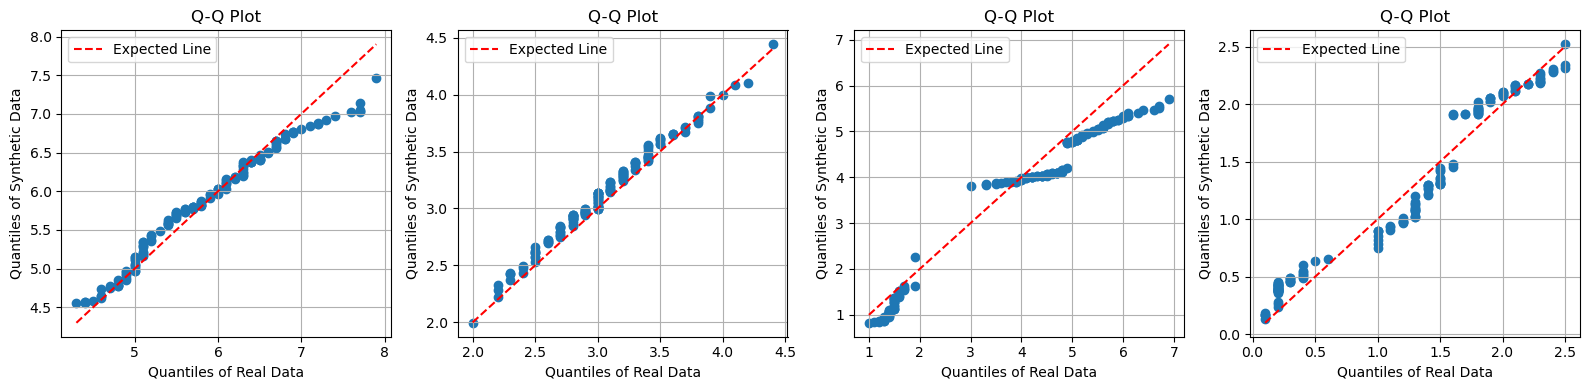

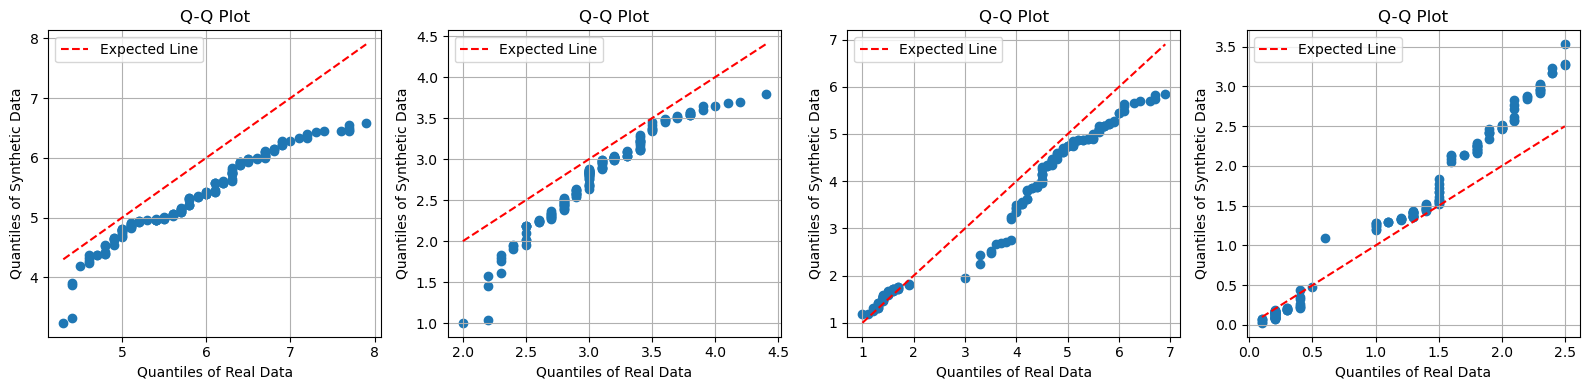

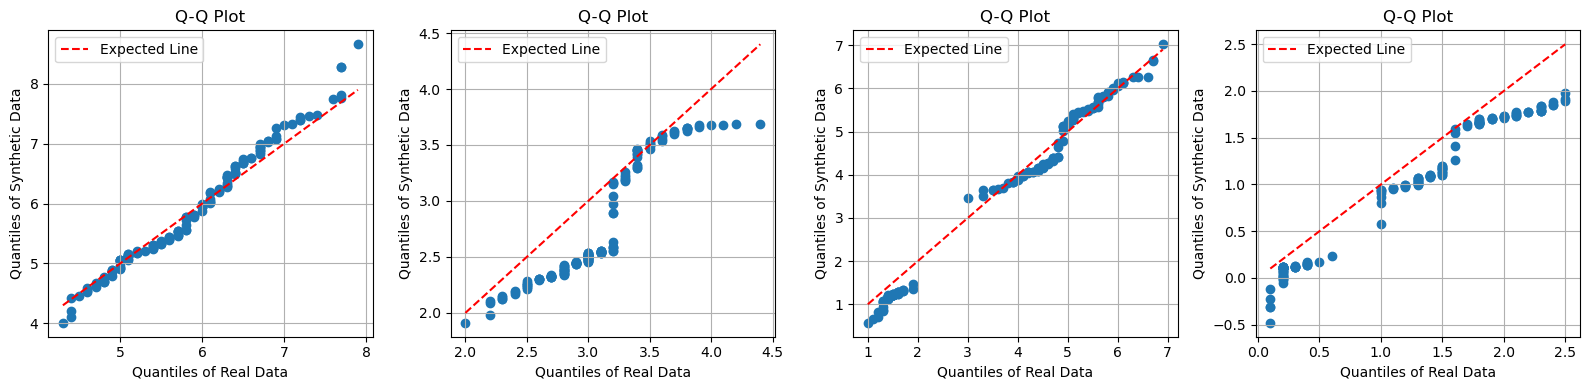

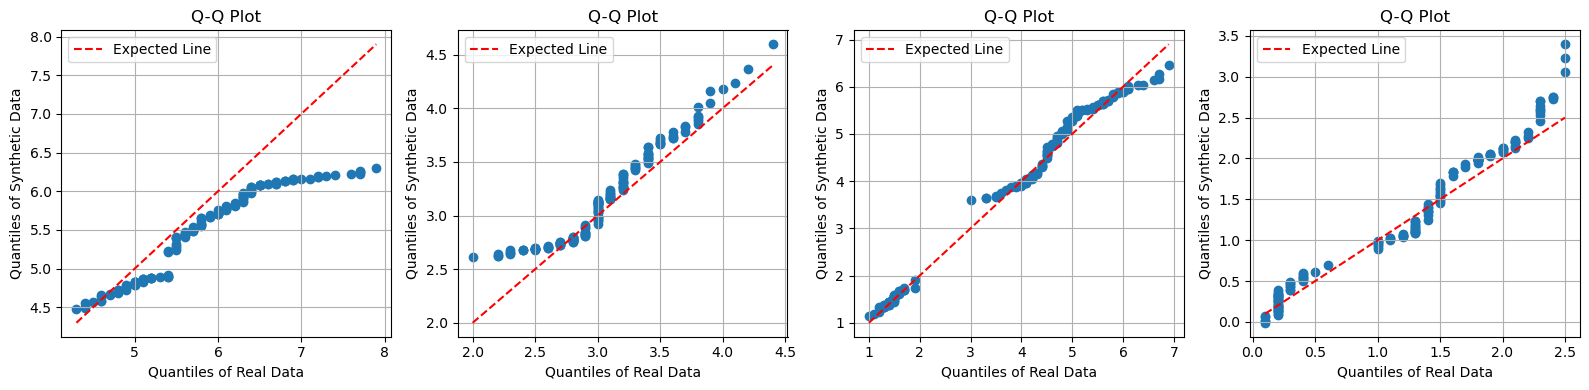

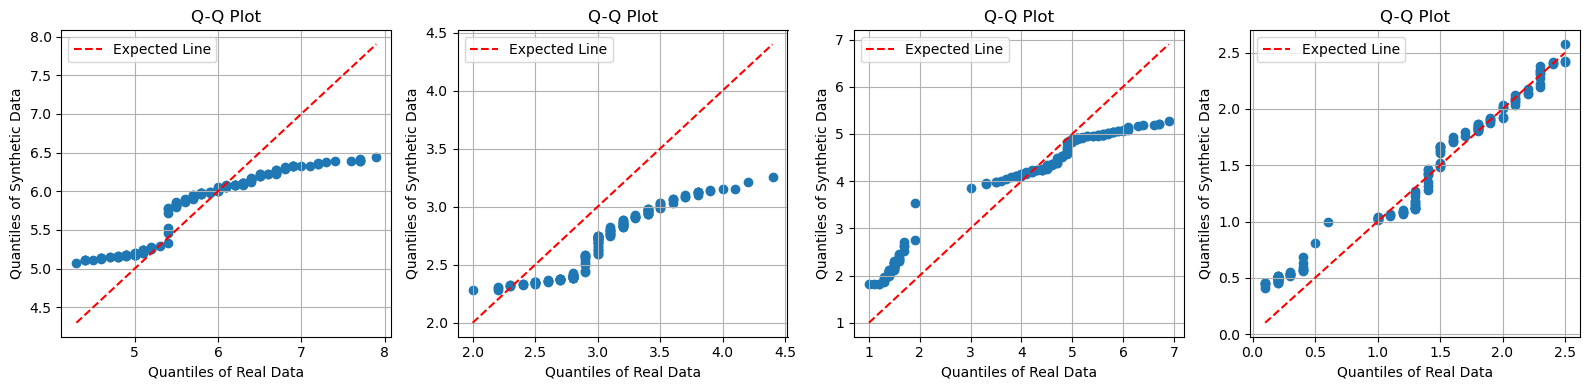

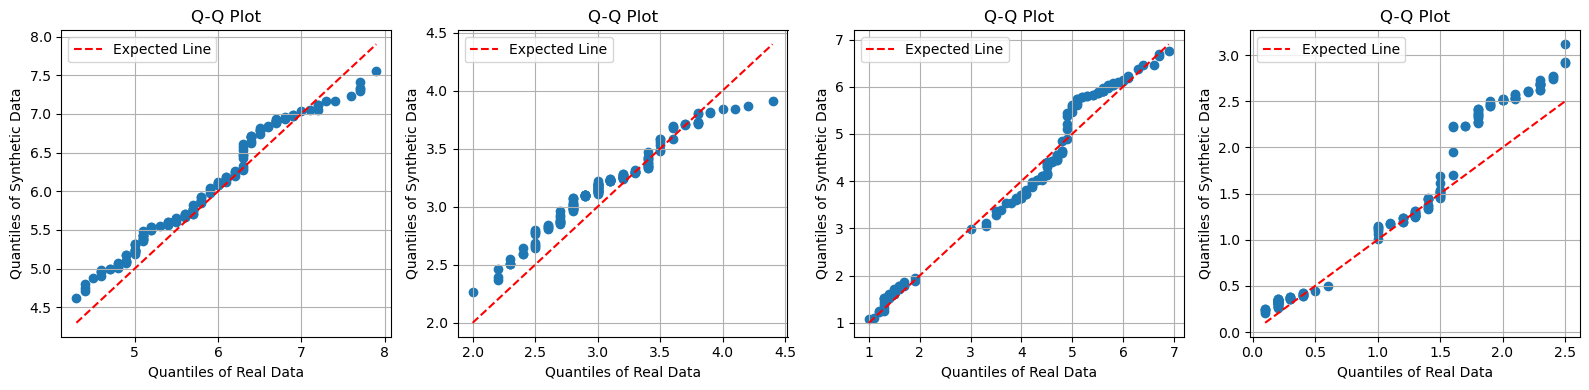

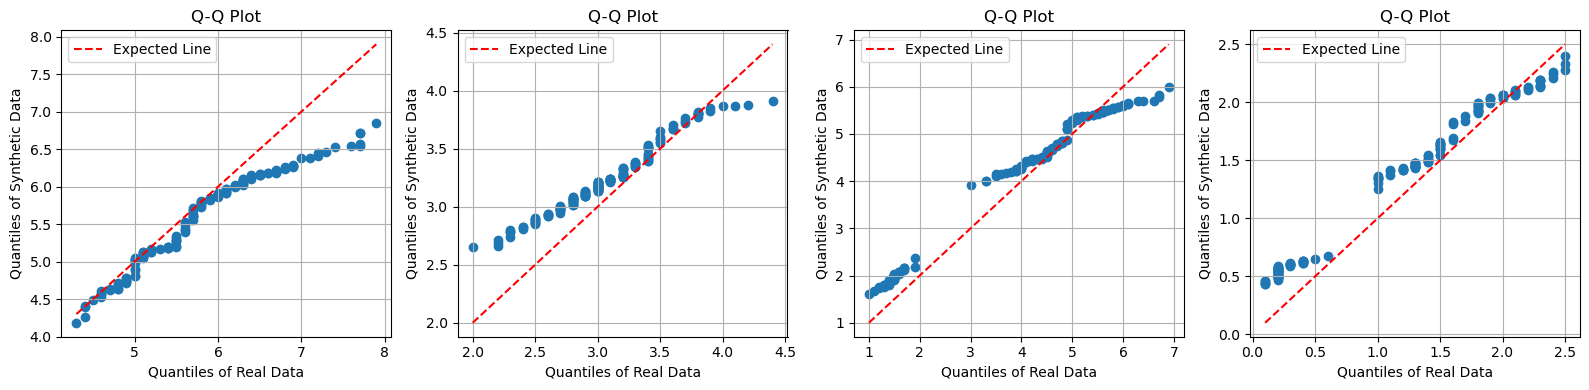

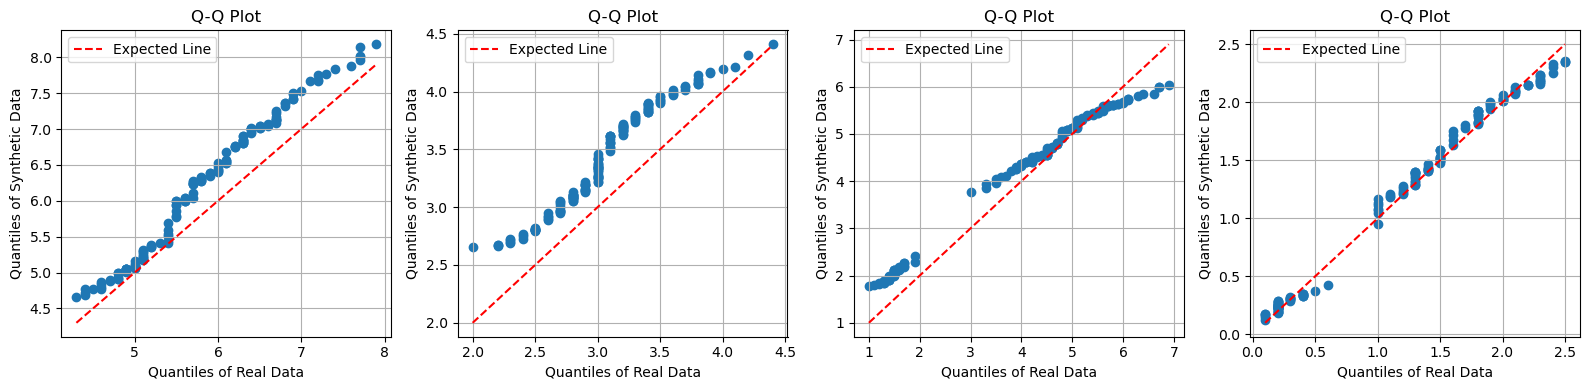

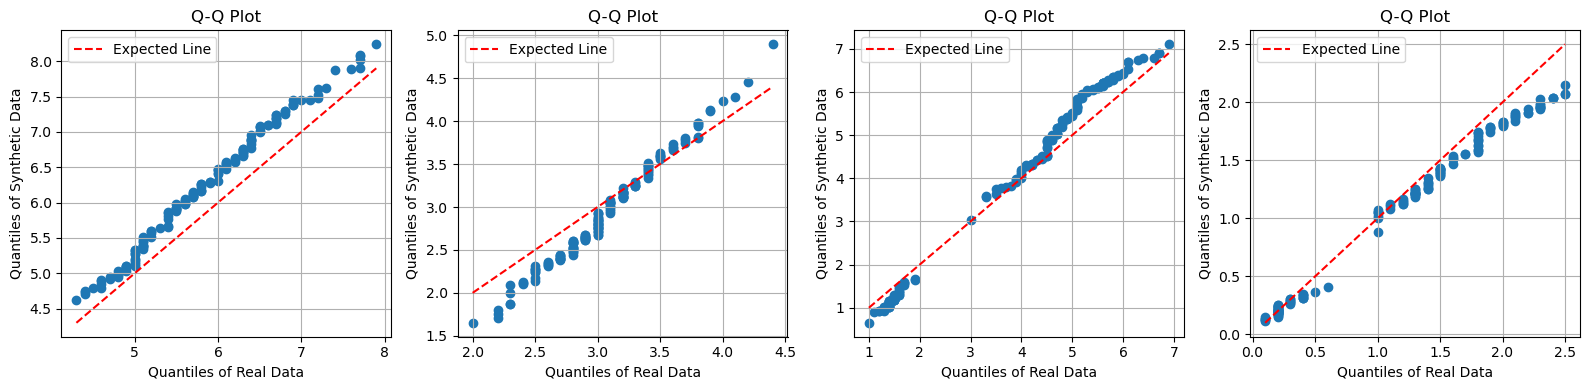

In [37]:
for idx, size in enumerate(noise_vector_model_dict['Noise Vector Size']):
    gen = Generator2(input_dim = size, num_classes = 3)
    gen.load_state_dict(noise_vector_model_dict['Gen state dict'][idx])
    
    set_seed()
    z = torch.randn(150, size)
    
    generated_data = gen(z, real_gan_dataloader.dataset.label)
    fake_df = pd.DataFrame(std_scl.inverse_transform(generated_data.detach().numpy()))
    fake_df['target'] = y
    fake_df['target'] = fake_df['target'].map({i: species[i] for i in range(len(species))})
    fake_df.columns = real_iris.columns
    
    utils.plot_quantiles(real_iris, fake_df)

Looking at the Q-Q plots we clearly see more overlap between the distributions in the case of a noise vector of size 256. We can move on to generate a dataset to compare the distributions for each class.

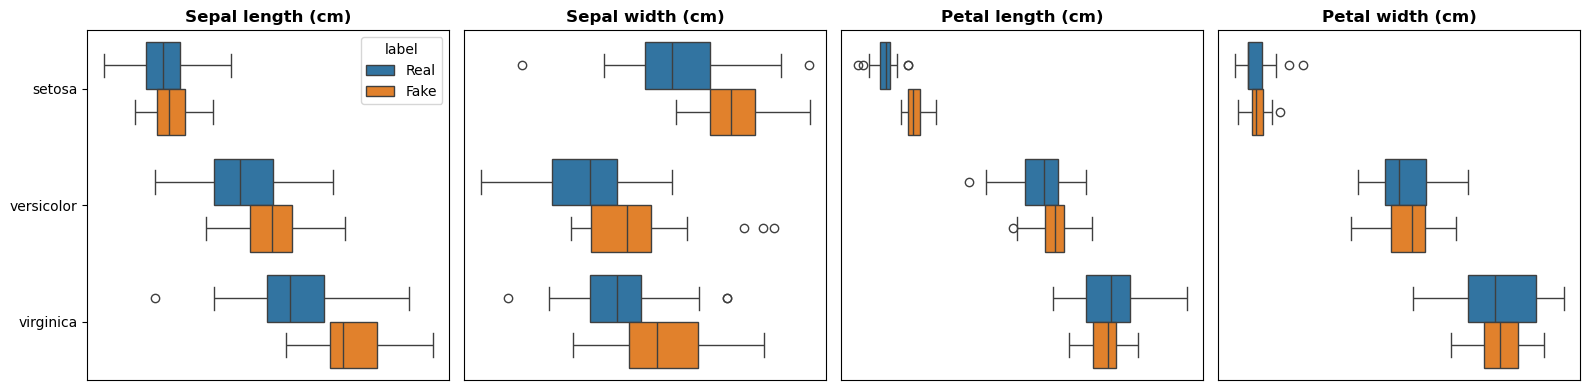

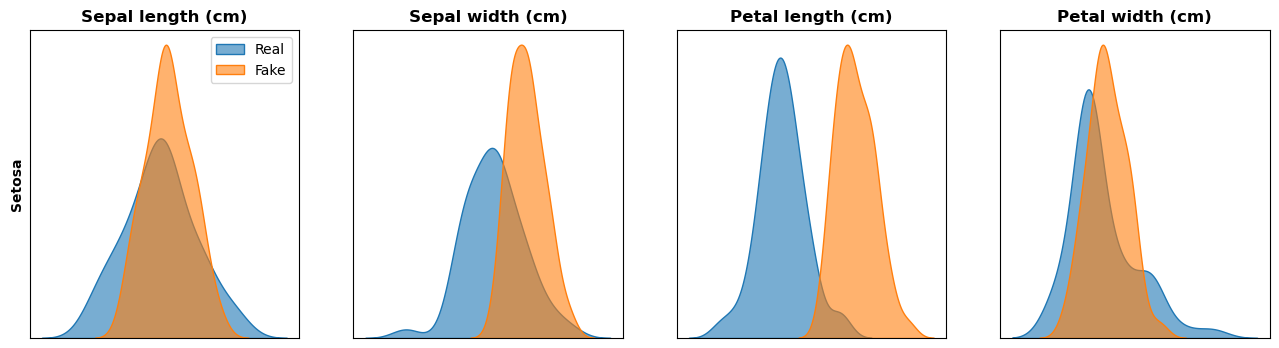

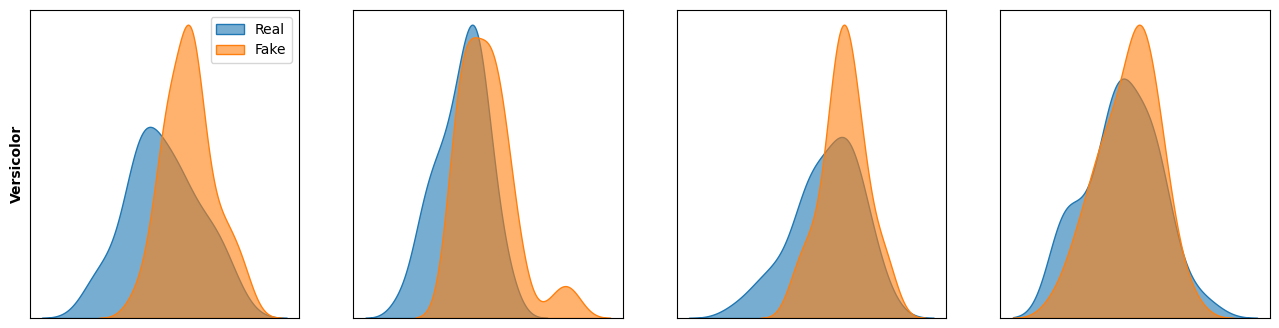

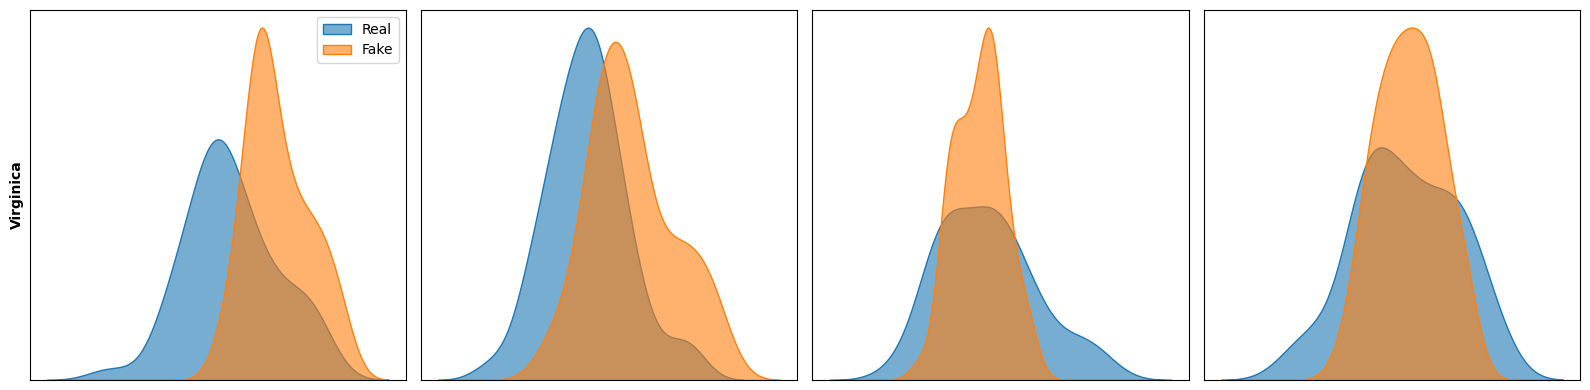

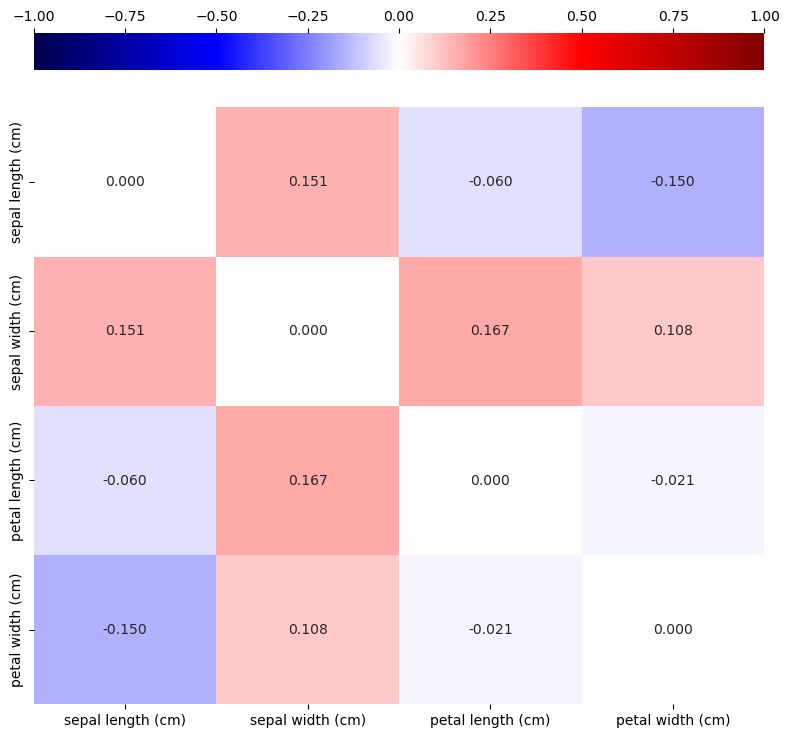

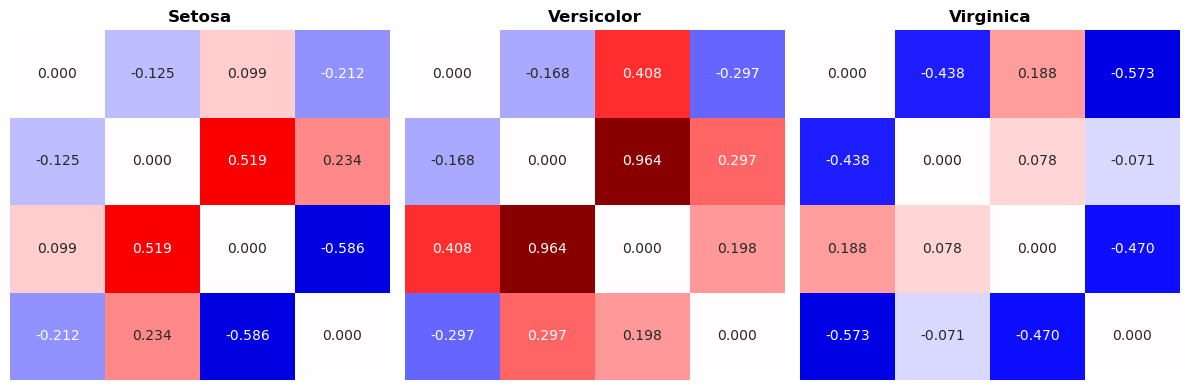

In [38]:
gen = Generator2(input_dim = 256, num_classes = 3)
gen.load_state_dict(noise_vector_model_dict['Gen state dict'][-2])

set_seed()
z = torch.randn(150, 256)

fake_data = gen(z, real_gan_dataloader.dataset.label)
gan_df = pd.DataFrame(std_scl.inverse_transform(fake_data.detach().numpy()))
gan_df['target'] = y
gan_df['target'] = gan_df['target'].map({i: species[i] for i in range(len(species))})
gan_df.columns = real_iris.columns

utils.plot_data(real_iris, 'target', gan_df)

Also analyzing the distributions of each variable divided by class we see good overlap; we found the best architecture and the crucial hyperparameter of the noise vector size. We can move on to refine the results.

## Fine Tuning the CGAN
First of all let's set a new class for our GAN nets using the best noise vector size.

In [39]:
noise_dim = 256

class Generator(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 4),
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x
    
class Discriminator(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
            
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x

gen = Generator(input_dim = 256, num_classes = 3)
disc = Discriminator(input_dim = 4, num_classes = 3)

print(f'Generator parameters: {sum(p.numel() for p in gen.parameters())/1000}k')
print(f'Discriminator parameters: {sum(p.numel() for p in disc.parameters())/1000}k')

Generator parameters: 19.325k
Discriminator parameters: 3.146k


Although the models do not have the same number of parameters, they have different orders of magnitude, the synthetic data of the generator still show good overlap with the real ones so this difference is necessary for a good result.

To further test, and in a more robust way, the distance between the distributions, the Kolmogorov-Smirnov test will be used to verify that the two distributions, real and synthetic, are from the same population.

In [40]:
utils.calculate_ks_test(real_iris.select_dtypes('number'), fake_df.select_dtypes('number'))

,Feature,KS Statistic,P-Value
0,sepal length (cm),0.206667,0.003221
1,sepal width (cm),0.240000,0.000335
2,petal length (cm),0.226667,0.000863
3,petal width (cm),0.146667,0.079310


It can be seen that for the first three features the KS test shows a significant distance between the respective real and synthetic distributions; for Petal Width the difference seems to be smaller (p = 0.079). Overall, the model needs some improvements.

It is well known that neural networks perform best when they exploit large amounts of data; having no additional data to train the model we can approach the problem from another perspective by performing feature engeeneering to increase the complexity of the task.

Taking advantage of Samy Baladram's work we will create some features of his [Iris Extended Dataset](https://www.kaggle.com/datasets/samybaladram/iris-dataset-extended).

Specifically:
$$ \text{Sepal Area} \rightarrow \text{Sepal Length} \times \text{Sepal Width} $$

$$ \text{Petal Area} \rightarrow \text{Petal Length} \times \text{Petal Width} $$

$$ \text{Sepal Aspect Ratio} \rightarrow \frac{\text{Sepal Length}}{\text{Sepal Width}} $$

$$ \text{Petal Aspect Ratio} \rightarrow \frac{\text{Petal Length}}{\text{Petal Width}} $$

$$ \text{Sepal to Petal Length Ratio} \rightarrow \frac{\text{Sepal Length}}{\text{Petal Length}} $$

$$ \text{Sepal to Petal Width Ratio} \rightarrow \frac{\text{Sepal Width}}{\text{Petal Width}} $$

$$ \text{Sepal Petal Length Difference} \rightarrow \text{Sepal Length} - \text{Petal Length} $$

$$ \text{Sepal Petal Width Difference} \rightarrow \text{Sepal Width} - \text{Petal Width} $$

In [41]:
aug_iris = real_iris.copy()

aug_iris['sepal area'] = aug_iris['sepal length (cm)'] * aug_iris['sepal width (cm)']
aug_iris['petal area'] = aug_iris['petal length (cm)'] * aug_iris['petal width (cm)']
aug_iris['sepal aspect ratio'] = aug_iris['sepal length (cm)'] / aug_iris['sepal width (cm)']
aug_iris['petal aspect ratio'] = aug_iris['petal length (cm)'] / aug_iris['petal width (cm)']
aug_iris['sepal petal length ratio'] = aug_iris['sepal length (cm)'] / aug_iris['petal length (cm)']
aug_iris['sepal petal width ratio'] = aug_iris['sepal width (cm)'] / aug_iris['petal width (cm)']
aug_iris['sepal petal length diff'] = aug_iris['sepal length (cm)'] - aug_iris['petal length (cm)']
aug_iris['sepal petal width diff'] = aug_iris['sepal width (cm)'] - aug_iris['petal width (cm)']

target_column = aug_iris.pop('target')
aug_iris['target'] = target_column
aug_iris

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),sepal area,petal area,sepal aspect ratio,petal aspect ratio,sepal petal length ratio,sepal petal width ratio,sepal petal length diff,sepal petal width diff,target
0,5.1,3.5,1.4,0.2,17.85,0.28,1.457143,7.000000,3.642857,17.500000,3.7,3.3,setosa
1,4.9,3.0,1.4,0.2,14.70,0.28,1.633333,7.000000,3.500000,15.000000,3.5,2.8,setosa
2,4.7,3.2,1.3,0.2,15.04,0.26,1.468750,6.500000,3.615385,16.000000,3.4,3.0,setosa
3,4.6,3.1,1.5,0.2,14.26,0.30,1.483871,7.500000,3.066667,15.500000,3.1,2.9,setosa
4,5.0,3.6,1.4,0.2,18.00,0.28,1.388889,7.000000,3.571429,18.000000,3.6,3.4,setosa
...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,20.10,11.96,2.233333,2.260870,1.288462,1.304348,1.5,0.7,virginica
146,6.3,2.5,5.0,1.9,15.75,9.50,2.520000,2.631579,1.260000,1.315789,1.3,0.6,virginica
147,6.5,3.0,5.2,2.0,19.50,10.40,2.166667,2.600000,1.250000,1.500000,1.3,1.0,virginica
148,6.2,3.4,5.4,2.3,21.08,12.42,1.823529,2.347826,1.148148,1.478261,0.8,1.1,virginica


Now we have to preprocess the new real data.

In [42]:
X, y = aug_iris.select_dtypes('number'), y

std_scl = StandardScaler()
X_scld = std_scl.fit_transform(X)

aug_real_gan_dataset = IrisDataset(X_scld, y)
aug_real_gan_dataloader = DataLoader(aug_real_gan_dataset, batch_size = 32, shuffle= True)

for batch in aug_real_gan_dataloader:
    gan_batch = batch
    break
    
print(gan_batch[0].shape)
print(gan_batch[1].shape)

torch.Size([32, 12])
torch.Size([32])


Now let's check new GAN's models dimensions.

In [43]:
noise_dim = 256

class Generator(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 12),
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x
    
class Discriminator(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
            
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + num_classes, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        label_embeddings = self.label_emb(labels)
        x = torch.cat([x, label_embeddings], dim = 1)
        x = self.model(x)
        return x

gen = Generator(input_dim = 256, num_classes = 3)
disc = Discriminator(input_dim = 12, num_classes = 3)

print(f'Generator parameters: {sum(p.numel() for p in gen.parameters())/1000}k')
print(f'Discriminator parameters: {sum(p.numel() for p in disc.parameters())/1000}k')

Generator parameters: 19.461k
Discriminator parameters: 3.658k


The difference is still the same; it will be the data generated that will give us an idea of the usefulness of this addition.

In [44]:
g_opt = torch.optim.Adam(gen.parameters(), lr = 1e-3)
d_opt = torch.optim.Adam(disc.parameters(), lr = 1e-3)

criterion = nn.BCELoss()

set_seed()
z = torch.randn(150, 256)

In [45]:
for epoch in tqdm(range(501), desc = 'Training Conditional GAN'):
    
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    
    disc.train()
    gen.train()
    
    for data, labels in aug_real_gan_dataloader:
        
        real_data = data
        real_labels = torch.ones(real_data.shape[0], 1)
        
        train_z = torch.randn(real_data.shape[0], 256)
        fake_data = gen(train_z, labels)
        fake_labels = torch.zeros(real_data.shape[0], 1)
        
        disc.zero_grad()
        
        real_loss = criterion(disc(real_data, labels), real_labels)
        fake_loss = criterion(disc(fake_data.detach(), labels), fake_labels)
        d_loss = (real_loss + fake_loss) / 2
        disc_epoch_loss += d_loss.item()
        d_loss.backward()
        
        d_opt.step()
        
        gen.zero_grad()
        
        gen_labels = torch.ones(real_data.shape[0], 1)
        
        g_loss = criterion(disc(fake_data, labels), gen_labels)
        gen_epoch_loss += g_loss.item()
        g_loss.backward()
        
        g_opt.step()
        
    g_epoch_loss = gen_epoch_loss/len(real_gan_dataloader)
    d_epoch_loss = disc_epoch_loss/len(real_gan_dataloader)
    
    if epoch % 50 == 0 or epoch == 500:
        
        print(f'\nEpoch {epoch}/500 | DLoss: {d_epoch_loss:.4f} | GLoss {g_epoch_loss:.4f}')
        with torch.no_grad():
            gen.eval()
            gen_z = gen(z, real_gan_dataloader.dataset.label)
            utils.compare_results(aug_real_gan_dataloader.dataset.data, gen_z)

Training Conditional GAN:   0%|          | 0/501 [00:00<?, ?it/s]


Epoch 0/500 | DLoss: 0.7029 | GLoss 0.7703
MEAN: [-0.177 -0.005 -0.095 -0.237 -0.02   0.147 -0.095  0.042  0.084 -0.012
 -0.139 -0.112]
STD:  [0.978 0.979 0.985 0.967 0.986 0.983 0.95  0.975 0.977 0.975 0.965 0.983]
MIN:  [-1.992 -2.37  -1.619 -1.588 -2.308 -1.007 -1.712 -0.772 -0.76  -0.637
 -1.629 -1.613]
MAX:  [2.228 3.016 1.637 1.361 3.567 2.236 2.28  4.242 2.67  4.255 2.009 1.955]
SKEW: [-0.121  0.259 -0.534 -0.725  0.278  0.496 -0.634  1.755  1.178  1.85
  0.201  0.163]
KURT: [-0.662 -0.237 -1.09  -2.256  0.804 -1.113 -0.884  5.035 -1.02   3.409
 -1.724 -1.38 ]

Epoch 50/500 | DLoss: 0.4957 | GLoss 4.8954
MEAN: [-0.86   3.454 -0.967 -1.839  0.336 -0.971 -2.217 -0.528  2.709  1.725
  0.448  2.766]
STD:  [ 0.614 -1.384  0.39  -0.11   0.819  0.269 -0.398  0.622 -0.734 -0.078
  0.734 -0.839]
MIN:  [-2.159  8.947 -1.665 -1.746 -1.46  -1.174 -1.985 -0.865  7.58   4.598
 -0.246  7.3  ]
MAX:  [ 0.295  3.247 -1.346 -3.798  3.721 -1.335 -4.425  2.55   2.986  4.577
  2.372  2.379]
SKEW: [-

In [50]:
fake_data[:, :4]

tensor([[ 1.8851e-01,  2.6084e+00, -1.3799e+00, -1.3629e+00],
        [-1.1003e+00,  4.7636e-01, -1.0125e+00, -1.3094e+00],
        [-5.2073e-01,  1.4539e+00, -1.0246e+00, -1.3135e+00],
        [-1.5449e+00,  8.3134e-02, -1.1250e+00, -1.3331e+00],
        [-9.1447e-01,  1.1655e+00, -1.1463e+00, -1.5245e+00],
        [-1.3792e+00,  1.1180e-01, -1.0258e+00, -1.2230e+00],
        [-1.4037e+00,  1.2969e-01, -1.0533e+00, -1.2597e+00],
        [-1.1974e+00,  3.3870e-01, -1.0504e+00, -1.2997e+00],
        [-1.2016e+00,  3.8350e-01, -1.0368e+00, -1.3161e+00],
        [-1.1358e+00,  8.4951e-01, -1.1845e+00, -1.5221e+00],
        [-1.3187e+00,  1.3036e-01, -1.0090e+00, -1.2020e+00],
        [-1.2166e+00,  6.2784e-01, -1.1235e+00, -1.5262e+00],
        [-1.4286e+00,  2.7508e-01, -1.1581e+00, -1.3996e+00],
        [-1.4656e+00, -1.3107e-01, -9.7581e-01, -1.0266e+00],
        [-1.1104e+00,  5.9039e-01, -1.0545e+00, -1.3931e+00],
        [-8.0556e-01,  1.3641e+00, -1.1569e+00, -1.5150e+00],
        

In [52]:
fake_data = gen(z, real_gan_dataloader.dataset.label)
gan_df = pd.DataFrame(std_scl.inverse_transform(fake_data.detach().numpy()))
gan_df['target'] = y
gan_df['target'] = gan_df['target'].map({i: species[i] for i in range(len(species))})
gan_df.columns = real_iris.columns

ValueError: Length mismatch: Expected axis has 13 elements, new values have 5 elements

In [ ]:
utils.plot_quantiles(real_iris.select_dtypes('number').iloc[:, :4], gan_df.select_dtypes('number').iloc[:, :4])

In [ ]:
utils.plot_data(real_iris[['sepal length (cm)', 'sepal width (cm)', '','target']], 'target', gan_df)

In [ ]:
real_gan_dataloader.dataset.data